# TER Picopatt - Analyse des données 

##  1) Importation des librairies et configuration des chemins

 Importation des librairies principales et définition des dossiers de travail.

In [23]:
from pathlib import Path
import re, unicodedata
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from zoneinfo import ZoneInfo  

def create_folder(path):
    """Crée le dossier si nécessaire avant d'enregistrer un fichier."""
    path = Path(path)
    path.mkdir(parents=True, exist_ok=True)
    
# Dossiers de données et de sortie
DATA_DIR = Path("../picopatt-database/dataproc")
OUTPUT_DIR = Path("./outputs"); OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
FIG_DIR = OUTPUT_DIR / "figures"; FIG_DIR.mkdir(parents=True, exist_ok=True)

create_folder(OUTPUT_DIR)
create_folder(FIG_DIR)

# Affichage complet des colonnes
pd.set_option("display.max_columns", 200)

## 2) Fonctions utilitaires

Définition de fonctions pour normaliser les textes, extraire le nom du parcours, parser les dates et attribuer un créneau horaire ('M1'
'M4').

In [24]:
def strip_accents(s):
    """ 
    Supprime les accents d'une chaîne
    """ 
    if pd.isna(s): return s
    return ''.join(c for c in unicodedata.normalize('NFKD', str(s)) if not unicodedata.combining(c))

def normalize_track(x):
    """
    Nettoie et rassemble les noms de parcours
    """ 
    if pd.isna(x): return np.nan
    x = strip_accents(str(x)).lower().strip()
    x = x.replace("boulevard", "boulevards")
    if "antigone" in x: return "antigone"
    if "boulevards" in x: return "boulevards"
    if "ecusson" in x: return "ecusson"
    return np.nan

def infer_track_from_filename(name: str):
    """
    Déduit le parcours à partir du nom du fichier
    """  
    n = strip_accents(name.lower())
    if "antigone" in n:   return "antigone"
    if "boulevard" in n:  return "boulevards"
    if "ecusson" in n:    return "ecusson"
    return np.nan

def parse_fr_ts(s):
    """
    Convertit les dates au format français en 
    """
    return pd.to_datetime(s, errors="coerce", dayfirst=True)

def assign_mslot_dst(ts_series: pd.Series, tz_name: str = "Europe/Paris") -> pd.Series:
    """
    M1..M4 en tenant compte DST (hiver UTC+1, été UTC+2).
    Hiver :
      M1 08-11, M2 11-14, M3 14-17, M4 17-20
    Été :
      M1 09-12, M2 12-15, M3 15-18, M4 18-21
    Intervalles [début, fin)
    """
    s = pd.to_datetime(ts_series, errors="coerce", dayfirst=True)

    # Localisation Europe/Paris
    s_loc = s.dt.tz_localize(
        ZoneInfo(tz_name),
        ambiguous="infer",
        nonexistent="shift_forward"
    )

    # Récupère le décalage UTC pour détecter été/hiver
    off = s_loc.map(lambda x: x.utcoffset())
    is_summer = off >= pd.Timedelta(hours=2)

    hh = s_loc.dt.hour

    conds, labels = [], []
    # Hiver
    conds += [
        (~is_summer) & (hh.between(8,10)),   # 08:00..10:59
        (~is_summer) & (hh.between(11,13)),  # 11:00..13:59
        (~is_summer) & (hh.between(14,16)),  # 14:00..16:59
        (~is_summer) & (hh.between(17,19)),  # 17:00..19:59
    ]
    labels += ["M1","M2","M3","M4"]

    # Été
    conds += [
        (is_summer) & (hh.between(9,11)),    # 09:00..11:59
        (is_summer) & (hh.between(12,14)),   # 12:00..14:59
        (is_summer) & (hh.between(15,17)),   # 15:00..17:59
        (is_summer) & (hh.between(18,20)),   # 18:00..20:59
    ]
    labels += ["M1","M2","M3","M4"]

    result = np.select(conds, labels, default=None)

    return pd.Series(result, index=ts_series.index, dtype="object")


## 3) Chargement et préparation des données

Lecture de tous les fichiers de données ('.csv', '.xlsx') dans le dossier 'DATAproc', nettoyage et harmonisation des colonnes, puis ajout des colonnes 'M_slot' (créneau horaire) et 'date'.

Nous préparons et vérifions les données brutes avant toute analyse.

Comme elles viennent de plusieurs fichiers, plusieurs jours, parcours, on va  :

les fusionner proprement dans un seul tableau,
uniformiser les colonnes (mêmes noms, même format),
et vérifier la couverture temporelle et la répartition des mesures.

In [25]:
def read_any(p: Path) -> pd.DataFrame:
    """
    Lit un fichier (CSV ou Excel), en essayant plusieurs séparateurs.
    """
    if p.suffix.lower() in (".xlsx", ".xls"):
        df = pd.read_excel(p)
    else:
        df = None
        for sep in [",", ";", "\t"]:
            try:
                temp = pd.read_csv(p, sep=sep)
                if temp.shape[1] >= 5: 
                    df = temp
                    break
            except Exception:
                continue
        if df is None:
            raise ValueError(f"Impossible de lire le fichier : {p}")
    df["__source_file"] = p.name
    return df


def load_all(data_dir: Path) -> pd.DataFrame:
    """
    Charge et fusionne tous les fichiers du dossier en un seul DataFrame.
    """
    paths = sorted([p for p in data_dir.rglob("*") if p.suffix.lower() in (".csv", ".xlsx", ".xls")])
    assert paths, f"Aucun fichier trouvé dans {data_dir.resolve()}"

    frames = []
    for p in paths:
        df = read_any(p)

        # Conversion du timestamp
        if "timestamp" in df.columns:
            df["timestamp"] = parse_fr_ts(df["timestamp"])

        # Normalisation du nom de parcours à partir du nom du fichier
        trk_file = infer_track_from_filename(p.name)
        if "track_id" not in df.columns:
            df["track_id"] = trk_file
        else:
            df["track_id"] = df["track_id"].map(normalize_track)
            if df["track_id"].notna().any():
                df["track_id"] = df["track_id"].ffill().bfill()
            df["track_id"] = df["track_id"].fillna(trk_file)

        # Fusion des coordonnées GPS RTK et ontrack
        for c in ["lon_rtk", "lat_rtk", "lon_ontrack", "lat_ontrack"]:
            if c not in df.columns:
                df[c] = np.nan
        df["lon"] = df["lon_rtk"].where(df["lon_rtk"].notna(), df["lon_ontrack"])
        df["lat"] = df["lat_rtk"].where(df["lat_rtk"].notna(), df["lat_ontrack"])

        frames.append(df)

    return pd.concat(frames, ignore_index=True, sort=False)

# Chargement complet
raw = load_all(DATA_DIR)

ts_local = pd.to_datetime(raw["timestamp"], errors="coerce", dayfirst=True) \
               .dt.tz_localize(ZoneInfo("Europe/Paris"), ambiguous="infer", nonexistent="shift_forward")
raw["M_slot"] = assign_mslot_dst(raw["timestamp"])
raw["date"]   = ts_local.dt.date

# Résumé rapide
print("Couverture :", raw["timestamp"].min(), "->", raw["timestamp"].max())
print("Parcours :", raw["track_id"].dropna().unique())
print(
    raw.pivot_table(index="track_id", columns="M_slot",
                    values="timestamp", aggfunc="count")
       .fillna(0)
       .astype(int)
)

C:\Users\antoc\AppData\Local\Temp\ipykernel_21296\3331964989.py:34: UserWarning: Parsing dates in %Y-%m-%d %H:%M:%S format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  return pd.to_datetime(s, errors="coerce", dayfirst=True)
C:\Users\antoc\AppData\Local\Temp\ipykernel_21296\3331964989.py:34: UserWarning: Parsing dates in %Y-%m-%d %H:%M:%S format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  return pd.to_datetime(s, errors="coerce", dayfirst=True)
C:\Users\antoc\AppData\Local\Temp\ipykernel_21296\3331964989.py:34: UserWarning: Parsing dates in %Y-%m-%d %H:%M:%S format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  return pd.to_datetime(s, errors="coerce", dayfirst=True)
C:\Users\antoc\AppData\Local\Temp\ipykernel_21296\3331964989.py:34: UserWarning: Parsing dates in %Y-%m-%d %H:%M:%S format when dayfirst=True was speci

Couverture : 2024-03-12 08:30:07 -> 2025-09-01 19:08:20
Parcours : ['antigone' 'boulevards' 'ecusson']
M_slot         M1     M2     M3     M4
track_id                              
antigone    29675  30263  31419  26696
boulevards  27959  33312  26151  27108
ecusson     30435  27041  26656  19730


## Résultat:

Les données couvrent un intervalle de temps.
On distingue trois zones de collecte principales du chariot : antigone, boulevards et ecusson.

On observe également quatre passages par jour (matin, midi, après-midi et soir), réalisés à différents moments de la journée.

Globalement, la base de données est bonne et bien équilibrée entre les parcours et les passages.
Cependant, on remarque que le parcours Écusson contient un peu moins de données, ce qui peut indiquer que certains passages n’ont pas été effectués, qu’un problème de mesure est survenu ou tout simplement moins de mesures ont été éffectues pour ecusson.

## 4) Analyse exploratoire rapide

### 4.1) Comptage global par parcours



Affiche la période couverte par les données, la liste des parcours disponibles, le taux de valeurs manquantes globales et des variables météo, et le nombre d’enregistrements par parcours et par créneau horaire ('M_slot').


Couverture temporelle : 2024-03-12 08:30:07 -> 2025-09-01 19:08:20
Parcours disponibles : ['antigone' 'boulevards' 'ecusson']
Taux de valeurs manquantes (top 20) :


project_id          0.999786
section_warning     0.999660
section_speed       0.988983
section_weather     0.988983
section_duration    0.988983
M_slot              0.014170
gnss_accuracy       0.000006
lat_rtk             0.000006
lon_rtk             0.000006
section_id          0.000000
track_id            0.000000
timestamp           0.000000
segment_id          0.000000
point_id            0.000000
lat_ontrack         0.000000
sun_azimuth         0.000000
sun_height          0.000000
tair_thermohygro    0.000000
lon_ontrack         0.000000
tair_tc2            0.000000
dtype: float64

Comptage par parcours :


track_id
antigone      121457
boulevards    115962
ecusson       103862
Name: count, dtype: int64

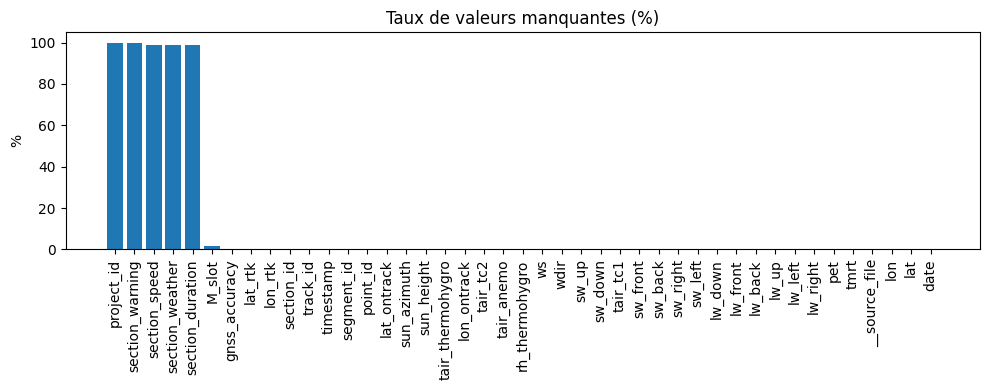

In [26]:
# Période temporelle couverte 
print("Couverture temporelle :", raw["timestamp"].min(), "->", raw["timestamp"].max())

# Liste des parcours présents dans les données
print("Parcours disponibles :", raw["track_id"].dropna().unique())

# Taux de valeurs manquantes (20 colonnes les plus concernées)
missing = raw.isna().mean().sort_values(ascending=False)
print("Taux de valeurs manquantes (top 20) :")
display(missing.head(20))

# Comptage global par parcours
print("Comptage par parcours :")
display(raw["track_id"].value_counts())

# Calcul du pourcentage de valeurs manquantes sur les variables météo
na = raw.isna().mean().sort_values(ascending=False) * 100

COMPT = FIG_DIR / "comptage"
create_folder(COMPT)

# Visualisation graphique
plt.figure(figsize=(10, 4))
plt.bar(na.index, na.values)
plt.title("Taux de valeurs manquantes (%)")
plt.xticks(rotation=90)
plt.ylabel("%")
plt.tight_layout()
plt.savefig(COMPT/"na_pct_vars.png", dpi=150)
plt.show()

## Résultat:

Les variables de mesures principales présentent très peu de valeurs manquantes, ce qui garantit une base de données fiable et exploitable.

Certaines colonnes pour les sections sont quasiment vides, ce qui est normal compte tenu de la configuration du jeu de données, et elles pourront donc être ignorées lors des analyses.

On observe également le nombre total de relevés par parcours, avec Écusson qui présente le volume le plus faible.


### 4.2) Comptage croisé : parcours x créneau horaire

 Carte de chaleur des échantillons par parcours et créneau horaire

Ce bloc affiche une **heatmap** montrant le **nombre d’échantillons collectés** pour chaque combinaison `parcours × M_slot` (M1 à M4).  
Cela permet d’identifier les périodes ou parcours avec plus ou moins de données.

Nombre d'échantillons par parcours et par créneau horaire :


M_slot         M1     M2     M3     M4
track_id                              
antigone    29675  30263  31419  26696
boulevards  27959  33312  26151  27108
ecusson     30435  27041  26656  19730

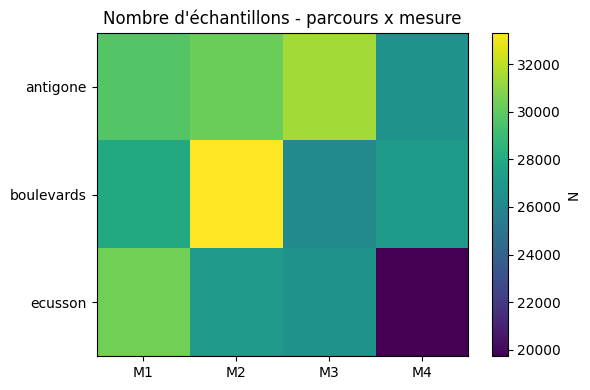

In [27]:
# Répartition des mesures par parcours et créneau horaire (M-slot)

# Comptage croisé : parcours × créneau horaire
raw["passage_slot"] = raw["M_slot"]

# Tableau récapitulatif du nombre de mesures
tab = (
    raw.dropna(subset=["track_id", "M_slot"])
       .pivot_table(
           index="track_id",
           columns="M_slot",
           values="timestamp",
           aggfunc="count",
           observed=True
       )
       .reindex(columns=["M1", "M2", "M3", "M4"])
       .fillna(0)
       .astype(int)
)

# Affichage du tableau
print("Nombre d'échantillons par parcours et par créneau horaire :")
display(tab)

# Heatmap
plt.figure(figsize=(6, 4))
plt.imshow(tab.values, aspect="auto")
plt.xticks(range(tab.shape[1]), tab.columns)
plt.yticks(range(tab.shape[0]), tab.index)
plt.title("Nombre d'échantillons - parcours x mesure")
plt.colorbar(label="N")
plt.tight_layout()

# Sauvegarde et affichage
plt.savefig(COMPT/"heatmap_counts_parcours_M.png", dpi=150)
plt.show()

# Résultat:


	•Le parcours Antigone possède le plus grand nombre de mesures sur l’ensemble des créneaux.
	•Le parcours Boulevards présente davantage de données sur le créneau M2 (midi), mais moins sur M3 (après-midi).
	•Le parcours Écusson contient globalement moins de mesures sur tous les créneaux.
	•Le jeu de données couvre bien les quatre créneaux horaires de la journée (M1, M2, M3, M4) pour chaque parcours.

#  5) Pourquoi Écusson a moins de données ?

C:\Users\antoc\AppData\Local\Temp\ipykernel_21296\167142037.py:25: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.drop_duplicates(subset=["date", "M_slot"]).shape[0])


track_id          date_debut            date_fin  nb_jours  nb_passages  \
0    antigone 2024-06-12 14:44:05 2025-09-01 19:08:20         8           30   
1  boulevards 2024-05-12 08:30:27 2025-07-01 19:10:08         7           25   
2     ecusson 2024-03-12 08:30:07 2025-01-14 19:18:28         7           21   

   M1  M2  M3  M4  
0   7   8   8   7  
1   7   7   5   6  
2   7   5   5   4

<Figure size 800x500 with 0 Axes>

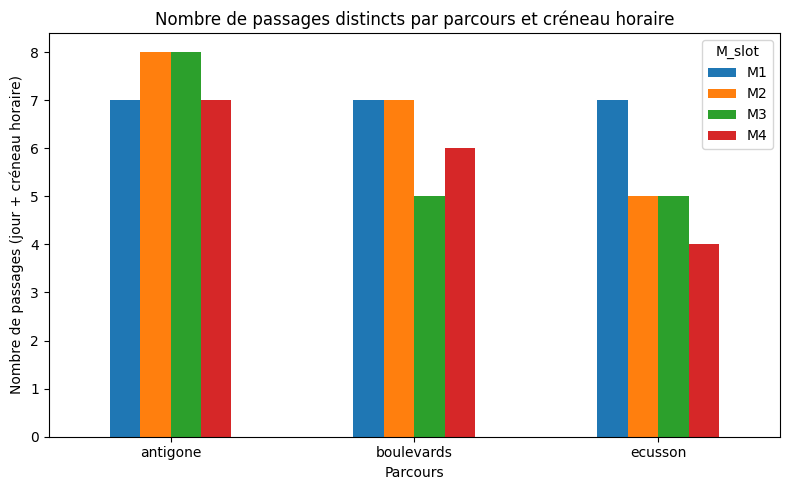

In [28]:
# Période de mesure et nombre de jours distincts
periode_parcours = (
    raw.dropna(subset=["track_id", "timestamp"])
       .groupby("track_id")
       .agg(
           date_debut=("timestamp", "min"),
           date_fin=("timestamp", "max"),
           nb_jours=("date", "nunique")
       )
       .reset_index()
)

# Nombre total de passages (jour + M_slot) par parcours
nb_passages_par_parcours = (
    raw.dropna(subset=["track_id", "M_slot", "date"])
       .groupby("track_id")[["date", "M_slot"]]
       .apply(lambda x: x.drop_duplicates(subset=["date", "M_slot"]).shape[0])
       .reset_index(name="nb_passages")
)

# Détail des passages par créneau horaire (M1, M2, M3, M4)
nb_passages_par_Mslot = (
    raw.dropna(subset=["track_id", "M_slot", "date"])
       .groupby(["track_id", "M_slot"])
       .apply(lambda x: x.drop_duplicates(subset=["date", "M_slot"]).shape[0])
       .reset_index(name="nb_passages")
       .pivot(index="track_id", columns="M_slot", values="nb_passages")
       .fillna(0)
       .astype(int)
)

# Fusion des résultats en un tableau unique
synthese_passages = (
    periode_parcours
    .merge(nb_passages_par_parcours, on="track_id", how="left")
    .merge(nb_passages_par_Mslot, on="track_id", how="left")
)

display(synthese_passages)

#Nombre de passages par parcours et créneau horaire

plt.figure(figsize=(8, 5))
nb_passages_par_Mslot.plot(
    kind="bar",
    figsize=(8, 5),
    rot=0,
    title="Nombre de passages distincts par parcours et créneau horaire"
)
plt.xlabel("Parcours")
plt.ylabel("Nombre de passages (jour + créneau horaire)")
plt.tight_layout()

# Sauvegarde et affichage
plt.savefig(COMPT/"nb_passages_distincts_par_Mslot.png", dpi=150)
plt.show()

In [29]:
# récupère uniquement les fichiers liés à "ecusson"
paths_ecusson = sorted([p for p in DATA_DIR.rglob("*ecusson*") if p.suffix.lower() in (".csv", ".xlsx", ".xls")])

#  lire un fichier et extraire les dates présentes
def get_dates_from_file(p):
    try:
        if p.suffix.lower() in (".xlsx", ".xls"):
            df = pd.read_excel(p)
        else:
            df = pd.read_csv(p, sep=None, engine="python")  # détection auto du séparateur
        if "timestamp" in df.columns:
            df["timestamp"] = pd.to_datetime(df["timestamp"], errors="coerce", dayfirst=True)
            return sorted(df["timestamp"].dropna().dt.date.unique())
        else:
            return []
    except Exception as e:
        print(f" Erreur lecture {p.name}: {e}")
        return []

#  tableau récapitulatif
file_dates = pd.DataFrame([
    {"fichier": p.name, "dates_trouvées": get_dates_from_file(p)}
    for p in paths_ecusson
])

# Affichage du résultat
display(file_dates)

#  combien de jours distincts au total :
all_dates = sorted({d for sublist in file_dates["dates_trouvées"] for d in sublist})
print(f"\n Nombre total de jours uniques mesurés pour ECUSSON : {len(all_dates)}")

C:\Users\antoc\AppData\Local\Temp\ipykernel_21296\1139846847.py:12: UserWarning: Parsing dates in %Y-%m-%d %H:%M:%S format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  df["timestamp"] = pd.to_datetime(df["timestamp"], errors="coerce", dayfirst=True)
C:\Users\antoc\AppData\Local\Temp\ipykernel_21296\1139846847.py:12: UserWarning: Parsing dates in %Y-%m-%d %H:%M:%S format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  df["timestamp"] = pd.to_datetime(df["timestamp"], errors="coerce", dayfirst=True)
C:\Users\antoc\AppData\Local\Temp\ipykernel_21296\1139846847.py:12: UserWarning: Parsing dates in %Y-%m-%d %H:%M:%S format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  df["timestamp"] = pd.to_datetime(df["timestamp"], errors="coerce", dayfirst=True)
C:\Users\antoc\AppData\Local\Temp\ipykernel_21296\1139846847.py:12: UserWarn

fichier dates_trouvées
0   picopatt_montpellier_ecusson_20241031_0827.csv   [2024-10-31]
1   picopatt_montpellier_ecusson_20241031_1127.csv   [2024-10-31]
2   picopatt_montpellier_ecusson_20241031_1425.csv   [2024-10-31]
3   picopatt_montpellier_ecusson_20241112_0830.csv   [2024-12-11]
4   picopatt_montpellier_ecusson_20241112_1124.csv   [2024-12-11]
5   picopatt_montpellier_ecusson_20241112_1430.csv   [2024-12-11]
6   picopatt_montpellier_ecusson_20241112_1723.csv   [2024-12-11]
7   picopatt_montpellier_ecusson_20241121_0832.csv   [2024-11-21]
8   picopatt_montpellier_ecusson_20241121_1729.csv   [2024-11-21]
9   picopatt_montpellier_ecusson_20241203_0829.csv   [2024-03-12]
10  picopatt_montpellier_ecusson_20241203_1128.csv   [2024-03-12]
11  picopatt_montpellier_ecusson_20241203_1423.csv   [2024-03-12]
12  picopatt_montpellier_ecusson_20241203_1743.csv   [2024-03-12]
13  picopatt_montpellier_ecusson_20241206_1005.csv   [2024-06-12]
14  picopatt_montpellier_ecusson_20241212_0829.csv   [2024-12-12]
15  picopatt_montpellier_ecusson_20241212_1125.csv   [2024-12-12]
16  picopatt_montpellier_ecusson_20241212_1425.csv   [2024-12-12]
17  picopatt_montpellier_ecusson_20250114_0832.csv   [2025-01-14]
18  picopatt_montpellier_ecusson_20250114_1130.csv   [2025-01-14]
19  picopatt_montpellier_ecusson_20250114_1427.csv   [2025-01-14]
20  picopatt_montpellier_ecusson_20250114_1726.csv   [2025-01-14]


 Nombre total de jours uniques mesurés pour ECUSSON : 7


## Resultat

Ces résultats montrent que les mesures ont été réalisées sur une période, mais seulement sur quelques journées d’acquisition par parcours.
Le parcours Antigone a bénéficié de la couverture la plus complète, tandis que Écusson présente le moins de passages.

Elle contient un jour en moins que antigone comme boulevards mais plsu explicite sur les passages ou elle detinet le moins de passages sur le parcours.

Cela montre pourquoi ecusson regroupe moins de valeur



# 5.1) Vérification des sections mesurées pour le parcours Écusson

In [30]:
# On isole le parcours "antigone"
df_ecusson = raw[raw["track_id"] == "ecusson"]

# Liste des sections présentes dans le fichier
sections_lues = sorted(df_ecusson["section_id"].dropna().unique())

# On suppose que le parcours doit avoir 75 sections
sections_theoriques = list(range(1, 76))

# On cherche les manquantes
sections_manquantes = sorted(set(sections_theoriques) - set(sections_lues))

print("Nombre total attendu :", len(sections_theoriques))
print("Nombre réellement lus :", len(sections_lues))
print("Sections manquantes :", sections_manquantes)

Nombre total attendu : 75
Nombre réellement lus : 73
Sections manquantes : [12, 32]


##  Résultat
Nous savons que le nombre de sections pour un oarcours écusson est de 73 ( vu dans les fichiers ).
On regarde les sections toujours manquantes dans tout les fichiers écusson ( si certains fichier n 'ont pas certaines sections du a des travaux sur une certaine periode, mais d autre fichiers ont cette donneé, on la conserve).


## Statistiques descriptives sur les variables météo

Calcul des statistiques globales, par parcours et par créneau horaire ('M_slot') sur les variables météorologiques présentes dans les données nettoyées (dossier clean_nozeros).

In [51]:
DATA_NOZERO = Path("outputs/clean_nozeros")

# Liste des variables météo présentes (sans sw_back et sw_down)
CANDIDATES = [
    "tair_thermohygro","tair_tc1","tair_tc2","tair_anemo",
    "rh_thermohygro","ws","wdir",
    "sw_up","sw_front","sw_right",
    "lw_up","lw_down","lw_front","lw_back","lw_left","lw_right",
    "tmrt","pet"
]
METEO = [c for c in CANDIDATES if c in raw.columns]
num_cols = [c for c in METEO if c != "wdir"]  # variables numériques classiques

raw = load_all(DATA_NOZERO)

ts_local = pd.to_datetime(raw["timestamp"], errors="coerce", dayfirst=True) \
               .dt.tz_localize(ZoneInfo("Europe/Paris"), ambiguous="infer", nonexistent="shift_forward")
raw["M_slot"] = assign_mslot_dst(raw["timestamp"])
raw["date"]   = ts_local.dt.date

# Résumé rapide
print("Couverture :", raw["timestamp"].min(), "->", raw["timestamp"].max())
print("Parcours :", raw["track_id"].dropna().unique())
print(
    raw.pivot_table(index="track_id", columns="M_slot",
                    values="timestamp", aggfunc="count")
       .fillna(0)
       .astype(int)
)

C:\Users\antoc\AppData\Local\Temp\ipykernel_21296\3331964989.py:34: UserWarning: Parsing dates in %Y-%m-%d %H:%M:%S format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  return pd.to_datetime(s, errors="coerce", dayfirst=True)
C:\Users\antoc\AppData\Local\Temp\ipykernel_21296\3331964989.py:34: UserWarning: Parsing dates in %Y-%m-%d %H:%M:%S format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  return pd.to_datetime(s, errors="coerce", dayfirst=True)
C:\Users\antoc\AppData\Local\Temp\ipykernel_21296\3331964989.py:34: UserWarning: Parsing dates in %Y-%m-%d %H:%M:%S format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  return pd.to_datetime(s, errors="coerce", dayfirst=True)
C:\Users\antoc\AppData\Local\Temp\ipykernel_21296\3331964989.py:34: UserWarning: Parsing dates in %Y-%m-%d %H:%M:%S format when dayfirst=True was speci

Couverture : 2024-10-29 08:36:30 -> 2025-01-16 19:26:41
Parcours : ['antigone' 'boulevards' 'ecusson']
M_slot         M1     M2     M3     M4
track_id                              
antigone    29468  29924  31828  30237
boulevards  25603  34594  25785  29938
ecusson     29841  27635  26656  19730


In [52]:
def summary_stats(df, cols):
    # Calcule les statistiques descriptives principales
    q = df[cols].quantile([.10, .25, .50, .75, .90], numeric_only=True).T
    return pd.DataFrame({
        "mean": df[cols].mean(numeric_only=True),
        "std": df[cols].std(numeric_only=True),
        "min": df[cols].min(numeric_only=True),
        "p10": q[.10], "p25": q[.25], "median": q[.50],
        "p75": q[.75], "p90": q[.90],
        "max": df[cols].max(numeric_only=True),
    })

def circular_mean_deg(s):
    # Moyenne circulaire pour les angles (direction du vent)
    r = np.deg2rad(s.dropna().astype(float) % 360.0)
    if r.size == 0: return np.nan
    ang = np.arctan2(np.sin(r).mean(), np.cos(r).mean())
    return np.rad2deg(ang) % 360.0

# Statistiques globales 
stats_global = summary_stats(raw, num_cols)
if "wdir" in METEO:
    stats_global.loc["wdir", "mean"] = circular_mean_deg(raw["wdir"])

STATS = OUTPUT_DIR / "stats"
create_folder(STATS)
stats_global.to_csv(STATS / "stats_global.xlsx")
display(stats_global)

mean         std         min         p10         p25  \
tair_thermohygro   12.322580    4.446766   -0.971618    6.489281    9.496071   
tair_tc1           20.773164  130.146941    0.007812    6.398438    9.359375   
tair_tc2           13.692911   53.698878    0.007812    6.515625    9.406250   
tair_anemo         14.543863    4.822161    1.000000    8.000000   11.000000   
rh_thermohygro     60.532089   12.035269   37.474861   45.279850   51.145037   
ws                  1.054359    0.871207    0.102889    0.257222    0.463000   
sw_up              66.664167   93.142589    0.000428    5.162209   13.390516   
sw_front           54.993113  104.226845    3.323424   14.277620   15.882575   
sw_right           57.173707   94.781859    2.769514   20.534338   21.522706   
lw_up             363.435073   27.405188  266.539351  326.625260  346.569614   
lw_down           392.040498   21.237942  330.894294  367.766874  378.494614   
lw_front          388.481091   21.107004  317.796248  362.602961  374.269418   
lw_back           386.614032   21.218601  309.552120  360.614658  372.675685   
lw_left           392.899925   21.681679  315.678162  366.339746  378.315567   
lw_right          388.480124   21.290265  313.077331  362.442659  373.935424   
tmrt               19.497133    8.799047    2.424655   12.040703   14.453339   
pet                11.353547    6.008448   -5.037205    4.861958    7.564301   
wdir              358.071813         NaN         NaN         NaN         NaN   

                      median         p75         p90          max  
tair_thermohygro   12.129015   15.034333   17.880903    25.053407  
tair_tc1           12.000000   15.023438   18.007812  2047.992188  
tair_tc2           11.976562   14.890625   17.929688  2047.992188  
tair_anemo         15.000000   17.000000   20.000000    30.000000  
rh_thermohygro     58.829862   69.543603   78.094377    87.657969  
ws                  0.874555    1.388999    2.109220    11.009102  
sw_up              34.227502   73.292929  165.724752   712.930225  
sw_front           26.655764   47.904116   89.354224   984.895425  
sw_right           30.016879   49.817298   92.842337   957.943577  
lw_up             365.492545  381.343028  396.241645   457.708289  
lw_down           389.877291  401.843456  423.239340   512.178666  
lw_front          387.172788  399.497117  418.987333   532.448403  
lw_back           385.021078  397.684957  416.675559   479.900517  
lw_left           391.906031  404.404981  423.392149   520.479126  
lw_right          387.902403  400.019540  417.740240   526.091224  
tmrt               17.208549   21.586146   27.927997    73.053752  
pet                10.410688   14.307505   19.030599    55.898584  
wdir                     NaN         NaN         NaN          NaN

In [53]:
# Statistiques par parcours
track_code = {
    "antigone": "a",
    "boulevard": "b",
    "ecusson": "e"
}

by_track = []
for t, g in raw.groupby("track_id", dropna=True):
    s = summary_stats(g, num_cols)
    if "wdir" in METEO:
        s.loc["wdir", "mean"] = circular_mean_deg(g["wdir"])
    s = s.reset_index(names="variable")

    # Ajout de la lettre du parcours à chaque variable
    suffix = track_code.get(t, t[:1].lower())
    s["variable"] = s["variable"] + f"_{suffix}"

    by_track.append(s)

stats_by_track = pd.concat(by_track, ignore_index=True)
stats_by_track.to_csv(STATS / "stats_par_parcours.xlsx", index=False)
display(stats_by_track)

variable        mean         std         min         p10  \
0   tair_thermohygro_a   14.245584    4.113195    5.629435    9.148928   
1           tair_tc1_a   14.160871    4.162505    5.390625    8.957813   
2           tair_tc2_a   14.132794    4.132840    5.367188    9.015625   
3         tair_anemo_a   16.576262    4.666686    7.000000   11.000000   
4     rh_thermohygro_a   68.086875   11.272769   41.478447   52.453498   
5                 ws_a    1.120058    0.931576    0.102889    0.257222   
6              sw_up_a   93.983147  104.843359    0.002999   14.830347   
7           sw_front_a   68.891622  112.767520    3.323424   14.268854   
8           sw_right_a   75.942238  118.619029    2.769514   20.474574   
9              lw_up_a  366.577550   28.594065  288.241808  327.358584   
10           lw_down_a  401.408397   22.367008  359.659400  376.483976   
11          lw_front_a  395.627175   21.671399  344.640752  369.077308   
12           lw_back_a  394.713319   21.466468  348.271464  367.932926   
13           lw_left_a  399.625614   22.474127  347.433442  372.089778   
14          lw_right_a  394.247870   21.871026  343.727495  367.371488   
15              tmrt_a   22.318479   10.062757    8.016661   13.302207   
16               pet_a   13.676098    6.334439    0.551952    6.743320   
17              wdir_a  358.670545         NaN         NaN         NaN   
18  tair_thermohygro_b   11.163543    3.093531    3.653391    7.354467   
19          tair_tc1_b   10.977110    3.172977    2.937500    6.914062   
20          tair_tc2_b   10.963355    3.128855    2.937500    6.968750   
21        tair_anemo_b   13.459711    3.384341    6.000000   10.000000   
22    rh_thermohygro_b   57.453884    9.418032   38.352255   44.894560   
23                ws_b    1.053199    0.886331    0.102889    0.102889   
24             sw_up_b   63.751051   90.567779    0.000428    5.770806   
25          sw_front_b   58.096344  120.075108   12.031909   14.305669   
26          sw_right_b   53.493043   86.141669   18.538585   20.583236   
27             lw_up_b  354.208220   23.608577  281.144396  320.965499   
28           lw_down_b  384.073349   13.689796  337.687523  367.555559   
29          lw_front_b  380.397707   14.702161  327.535134  361.161980   
30           lw_back_b  378.826236   14.447781  329.312336  359.969707   
31           lw_left_b  385.338992   15.884143  328.149792  364.669955   
32          lw_right_b  381.843550   15.814531  325.453064  361.413555   
33              tmrt_b   18.155075    8.010396    5.532615   11.739702   
34               pet_b   10.009802    4.726899   -1.556058    4.710048   
35              wdir_b    0.170682         NaN         NaN         NaN   
36  tair_thermohygro_e   11.367870    5.269717   -0.971618    5.020600   
37          tair_tc1_e   39.442929  234.775405    0.007812    5.210938   
38          tair_tc2_e   16.276075   97.767364    0.007812    5.351562   
39        tair_anemo_e   13.377616    5.536251    1.000000    7.000000   
40    rh_thermohygro_e   55.134283   11.039167   37.474861   42.724155   
41                ws_e    0.978825    0.768976    0.102889    0.154333   
42             sw_up_e   39.109146   70.522680    0.000428    2.311424   
43          sw_front_e   35.275333   64.045493    9.894890   14.244311   
44          sw_right_e   39.335112   63.523128   12.870521   20.523925   
45             lw_up_e  370.062025   27.183234  266.539351  332.664400   
46           lw_down_e  389.980935   22.585424  330.894294  360.970458   
47          lw_front_e  389.149511   23.242916  317.796248  358.358716   
48           lw_back_e  385.837745   23.716218  309.552120  354.876380   
49           lw_left_e  393.476641   23.564546  315.678162  363.104339   
50          lw_right_e  389.145020   23.712800  313.077331  358.541609   
51              tmrt_e   17.696240    7.056153    2.424655   11.064358   
52               pet_e   10.137830    6.079094   -5.037205    3.192674   
53              wd

In [54]:
# Statistiques par parcours et créneau horaire
by_mslot = []
for (t, mslot), g in raw.groupby(["track_id", "M_slot"], dropna=True):
    s = summary_stats(g, num_cols)
    if "wdir" in METEO and "wdir" in g.columns:
        s.loc["wdir", "mean"] = circular_mean_deg(g["wdir"])
    s = s.reset_index(names="variable")

    # Ajout du suffixe parcours + Mslot 
    # ex: 'v'_aM1
    suffix = track_code.get(t, t[:1].lower())
    s["variable"] = s["variable"] + f"_{suffix}{mslot}"

    by_mslot.append(s)

stats_track_M = pd.concat(by_mslot, ignore_index=True)

# Tri des variables par parcours et mslot
stats_track_M["sort_key"] = stats_track_M["variable"].str.extract(r"_(.M\d)").astype(str)
stats_track_M = stats_track_M.sort_values("variable").drop(columns="sort_key")

stats_track_M.to_csv(STATS / "stats_par_parcours_par_mesure.xlsx", index=False)
display(stats_track_M)

variable        mean        std         min         p10         p25  \
12   lw_back_aM1  384.779002  19.699960  351.538890  360.811563  368.169548   
30   lw_back_aM2  401.392051  20.743852  365.955424  375.464920  387.228131   
48   lw_back_aM3  401.486580  21.018241  348.271464  373.868172  391.266271   
66   lw_back_aM4  390.655730  19.413165  348.855602  368.780922  375.058050   
84   lw_back_bM1  366.744207  12.466019  329.312336  351.067982  358.070420   
..           ...         ...        ...         ...         ...         ...   
131       ws_bM4    0.772289   0.488889    0.102889    0.102889    0.360111   
149       ws_eM1    0.895144   0.672881    0.102889    0.102889    0.411555   
167       ws_eM2    1.068301   0.837990    0.102889    0.205778    0.463000   
185       ws_eM3    0.987694   0.745512    0.102889    0.180055    0.463000   
203       ws_eM4    0.967926   0.819321    0.102889    0.102889    0.411555   

         median         p75         p90         max  
12   381.446713  401.103398  416.322287  436.802259  
30   396.302418  417.005842  430.818197  475.119119  
48   398.757977  415.650105  433.582173  476.927509  
66   387.528022  409.869671  418.217432  436.832678  
84   367.089764  375.685884  383.389591  400.411764  
..          ...         ...         ...         ...  
131    0.720222    1.080332    1.440443    3.035220  
149    0.771666    1.234666    1.749110    7.202216  
167    0.874555    1.440443    2.160665    8.025326  
185    0.823110    1.337554    1.954887    7.407994  
203    0.771666    1.337554    2.006332    6.739216  

[216 rows x 10 columns]

##  Comparaison des parcours : moyennes globales et par créneau horaire

Ce bloc compare les moyennes des variables météo entre trois parcours d’intérêt :  
**Antigone**, **Boulevards** et **Écusson**.  
Une moyenne circulaire est utilisée pour la direction du vent ('wdir'), puis les résultats sont exportés.

In [55]:
# Sélection des parcours à comparer
tracks_focus = ["antigone", "boulevards", "ecusson"]
sub = raw[raw["track_id"].isin(tracks_focus)]

# Moyennes classiques + moyenne circulaire pour wdir
def means_with_circ(df):
    m = df[num_cols].mean(numeric_only=True)
    if "wdir" in METEO:
        m["wdir"] = circular_mean_deg(df["wdir"])
    return m

# Comparaison globale
comp = sub.groupby("track_id").apply(means_with_circ).T[tracks_focus]
COMP = STATS / "comparaison"
create_folder(COMP)
comp.to_excel(COMP/"comparaison_parcours_moyennes.xlsx")
display(comp)

C:\Users\antoc\AppData\Local\Temp\ipykernel_21296\2709137378.py:13: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  comp = sub.groupby("track_id").apply(means_with_circ).T[tracks_focus]


track_id            antigone  boulevards     ecusson
tair_thermohygro   14.245584   11.163543   11.367870
tair_tc1           14.160871   10.977110   39.442929
tair_tc2           14.132794   10.963355   16.276075
tair_anemo         16.576262   13.459711   13.377616
rh_thermohygro     68.086875   57.453884   55.134283
ws                  1.120058    1.053199    0.978825
sw_up              93.983147   63.751051   39.109146
sw_front           68.891622   58.096344   35.275333
sw_right           75.942238   53.493043   39.335112
lw_up             366.577550  354.208220  370.062025
lw_down           401.408397  384.073349  389.980935
lw_front          395.627175  380.397707  389.149511
lw_back           394.713319  378.826236  385.837745
lw_left           399.625614  385.338992  393.476641
lw_right          394.247870  381.843550  389.145020
tmrt               22.318479   18.155075   17.696240
pet                13.676098   10.009802   10.137830
wdir              358.670545    0.170682  355.046212

In [56]:
# Comparaison par créneau horaire (M_slot)
comp_M = sub.groupby(["track_id", "M_slot"]).apply(means_with_circ).unstack(0)
comp_M.to_excel(COMP / "comparaison_parcours_moyennes_par_mesures.xlsx")
display(comp_M.head())

C:\Users\antoc\AppData\Local\Temp\ipykernel_21296\2791700934.py:2: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  comp_M = sub.groupby(["track_id", "M_slot"]).apply(means_with_circ).unstack(0)


tair_thermohygro                         tair_tc1             \
track_id         antigone boulevards    ecusson   antigone boulevards   
M_slot                                                                  
M1              11.230290   7.751789   9.698088  11.140672   7.463679   
M2              15.155110  12.350004  12.603042  15.185272  12.301105   
M3              16.285820  13.495273  12.873941  16.188093  13.312911   
M4              14.136493  10.704745  10.128547  13.956573  10.443190   

                       tair_tc2                       tair_anemo             \
track_id     ecusson   antigone boulevards    ecusson   antigone boulevards   
M_slot                                                                        
M1        107.728004  11.152707   7.516047  27.124538  13.095901   9.732297   
M2         12.582525  15.104123  12.221174  12.859855  18.467852  15.273227   
M3         12.685751  16.126279  13.252151  12.654720  18.735453  15.885554   
M4          9.936172  13.977436  10.489546  10.006497  15.823296  12.465963   

                    rh_thermohygro                              ws             \
track_id    ecusson       antigone boulevards    ecusson  antigone boulevards   
M_slot                                                                          
M1        11.463255      78.088279  66.251010  60.619198  0.870851   1.029844   
M2        14.819251      66.861924  53.564450  49.930694  1.037226   1.379893   
M3        15.178984      60.962178  48.098712  49.289213  1.318787   0.965471   
M4        11.820071      67.051682  62.471082  62.023896  1.236165   0.772289   

                         sw_up                           sw_front              \
track_id   ecusson    antigone  boulevards    ecusson    antigone  boulevards   
M_slot                                                                          
M1        0.895144   51.843322   26.153574  21.789349   57.294475   42.538017   
M2        1.068301  155.443258  103.368889  64.687650  122.142090  101.152088   
M3        0.987694   73.366609   46.521484  30.096618   81.611997   66.611134   
M4        0.967926         NaN         NaN   2.920578   14.104893   14.378324   

                       sw_right                             lw_up              \
track_id    ecusson    antigone boulevards    ecusson    antigone  boulevards   
M_slot                                                                          
M1        27.819331   64.557909  45.178604  33.481060  362.998626  348.823927   
M2        62.605720  129.317880  88.873460  57.739076  372.613111  352.073169   
M3        30.971708   89.225273  52.462562  40.808745  368.493485  361.210655   
M4        14.086113   20.231956  20.654626  20.420569  362.075622  355.235307   

                         lw_down                            lw_front  \
track_id     ecusson    antigone  boulevards     ecusson    antigone   
M_slot                                                                 
M1        363.912943  388.889775  371.611605  384.257480  385.522765   
M2        373.876515  407.847553  387.754803  394.817582  401.838616   
M3        373.929622  409.522807  392.518670  396.223922  402.159969   
M4        368.794245  398.694770  383.201202  383.428470  392.450931   

                                     lw_back                          \
track_id  boulevards     ecusson    antigone  boulevards     ecusson   
M_slot                                                                 
M1        369.108451  383.091773  384.779002  366.744207  379.328357   
M2        383.138568  394.107337  401.392051  382.818876  391.214697   
M3        388.854802  394.873461  401.486580  387.513498  391.646317   
M4        379.605807  383.634145  390.655730  377.062893  380.304106   

             lw_left                            lw_right              \
track_id    antigone  boulevards     ecusson    antigone  boulevards   
M_slot                                                                 
M1        389

##  Matrices de corrélation par parcours

Ce bloc calcule et affiche les **corrélations entre les variables numériques**  pour chaque parcours ('track_id').  

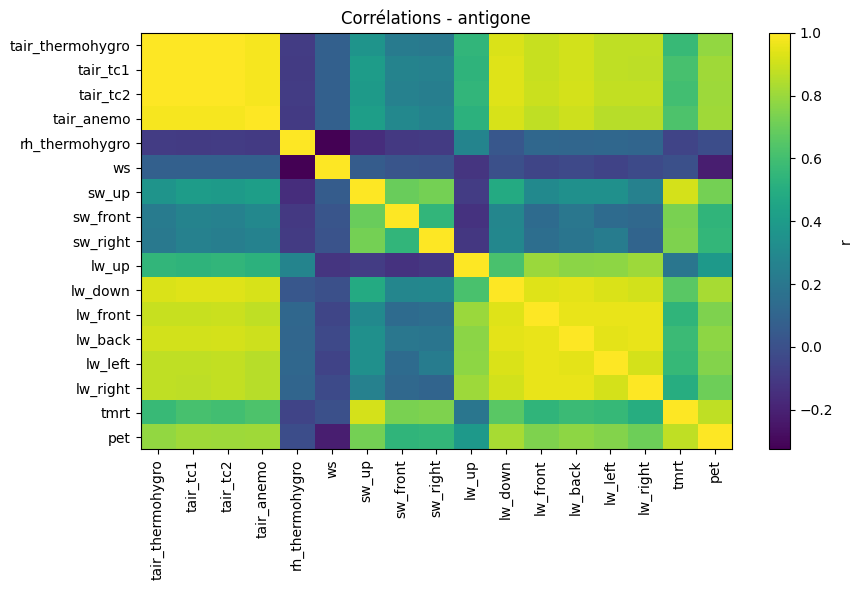

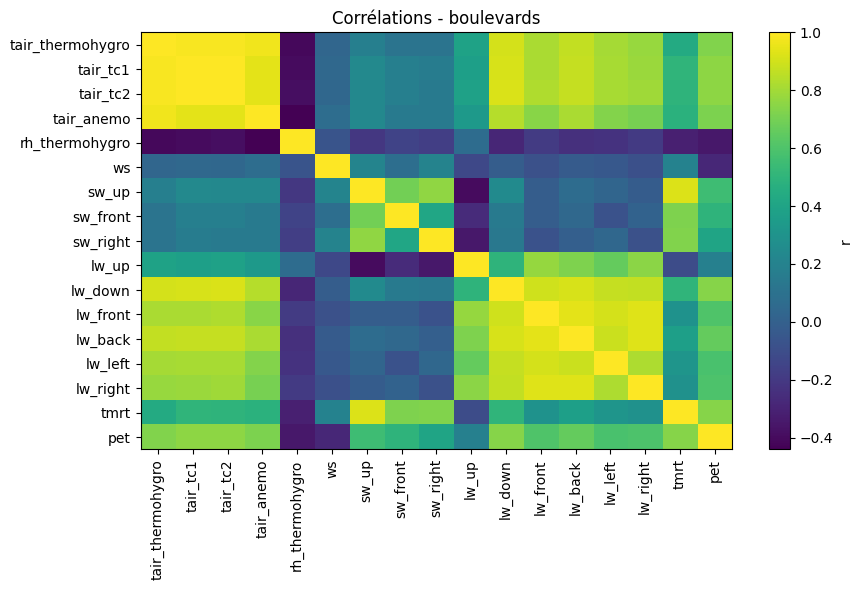

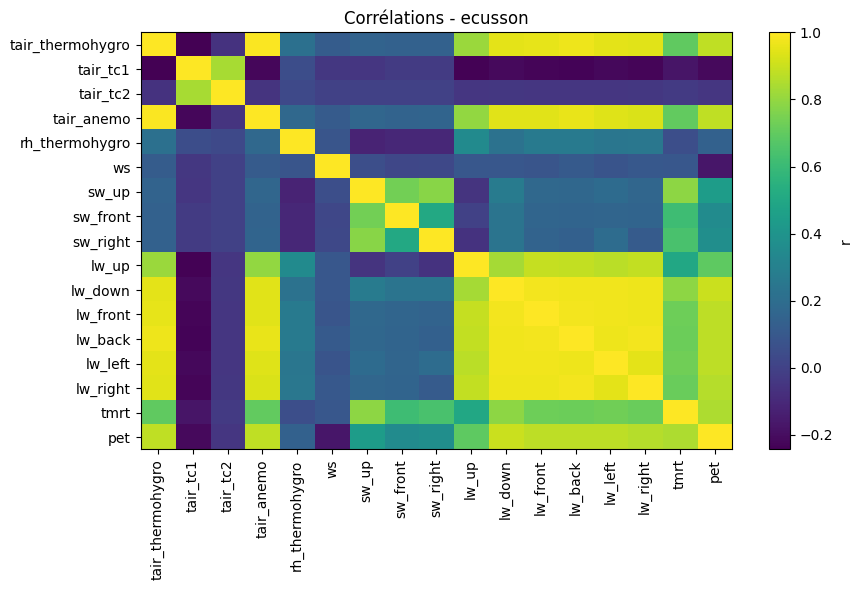

In [57]:
CORR = FIG_DIR / "correlation"
create_folder(CORR)

for t, g in raw.groupby("track_id"):
    # Sélection des variables numériques pertinentes
    sel = g[num_cols].select_dtypes(include=[np.number]).dropna(how="all", axis=1)
    
    if sel.shape[1] < 2: 
        print(f"Parcours {t} : pas assez de colonnes numériques pour corrélation.")
        continue

    # Calcul de la matrice de corrélation
    corr = sel.corr()

    # Visualisation
    plt.figure(figsize=(9, 6))
    plt.title(f"Corrélations - {t}")
    plt.imshow(corr, aspect="auto")
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
    plt.yticks(range(len(corr.index)), corr.index)
    plt.colorbar(label="r")
    plt.tight_layout()

    # Sauvegarde et affichage
    plt.savefig(CORR / f"corr_{t}.png", dpi=150)
    plt.show()

##  Distribution des variables météo par parcours

Ce bloc affiche des **boxplots** (boîtes à moustaches) pour comparer la distribution de chauques variables météorologiques clés entre les différents parcours (`track_id`).

C:\Users\antoc\AppData\Local\Temp\ipykernel_21296\2248143497.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(7, 4))


<Figure size 700x400 with 0 Axes>

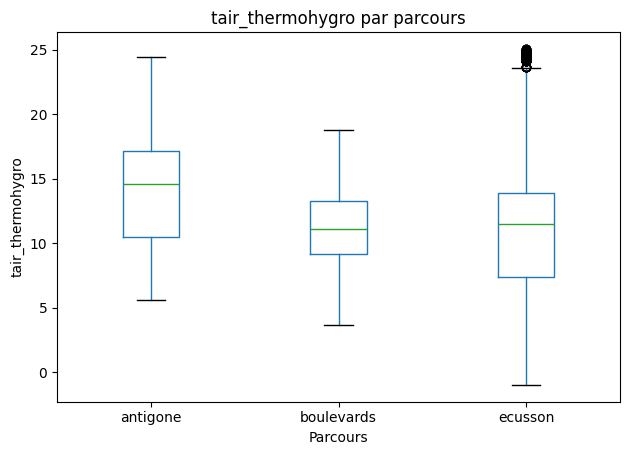

<Figure size 700x400 with 0 Axes>

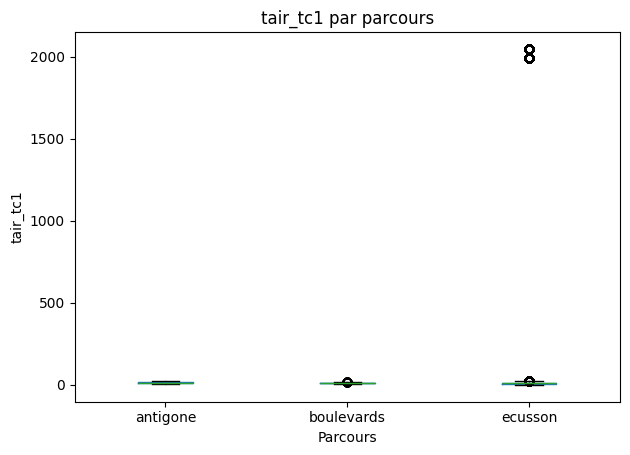

<Figure size 700x400 with 0 Axes>

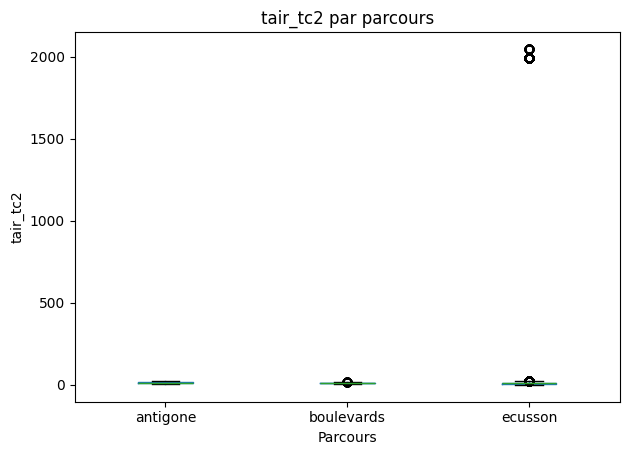

<Figure size 700x400 with 0 Axes>

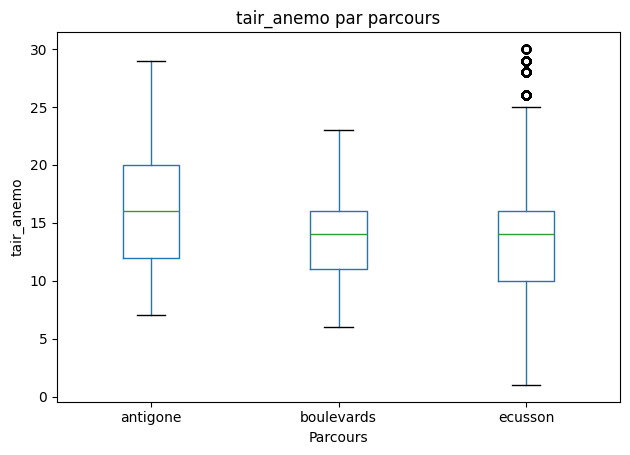

<Figure size 700x400 with 0 Axes>

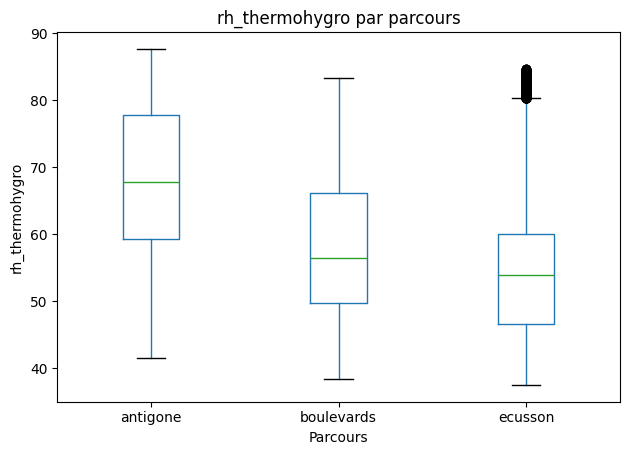

<Figure size 700x400 with 0 Axes>

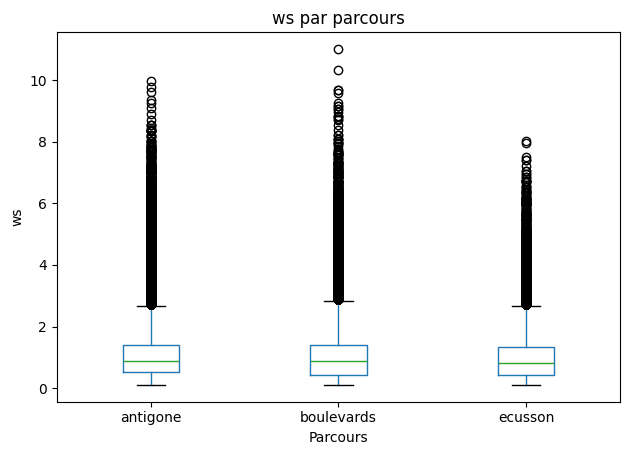

<Figure size 700x400 with 0 Axes>

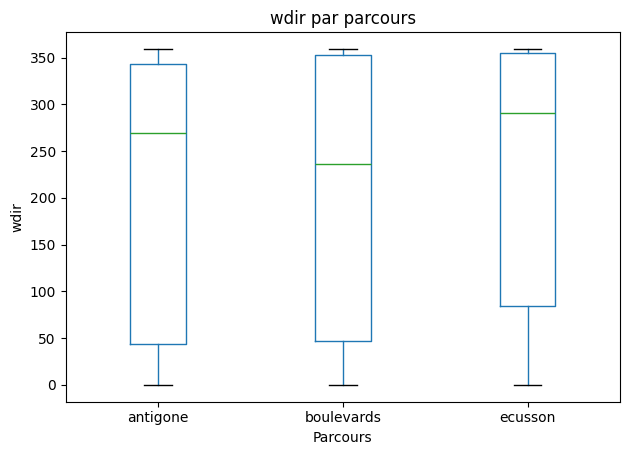

<Figure size 700x400 with 0 Axes>

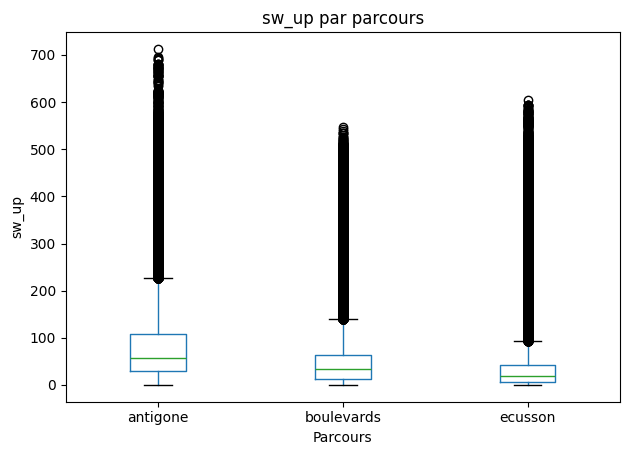

<Figure size 700x400 with 0 Axes>

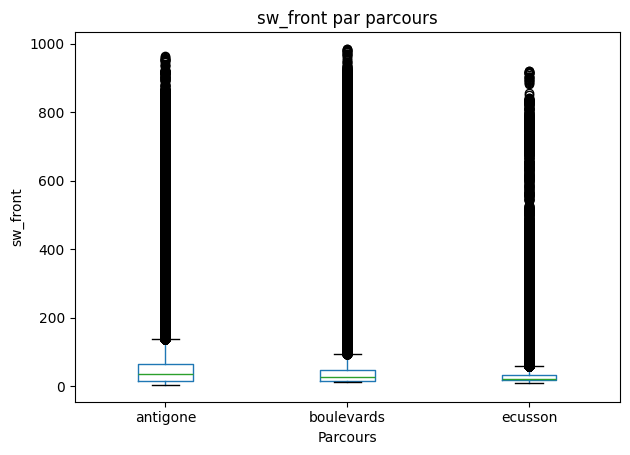

<Figure size 700x400 with 0 Axes>

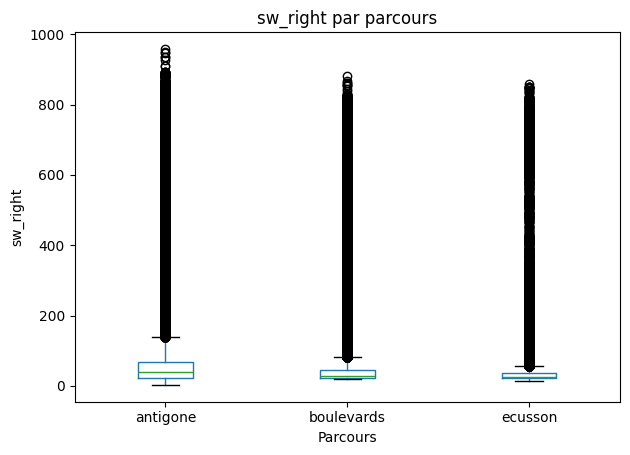

<Figure size 700x400 with 0 Axes>

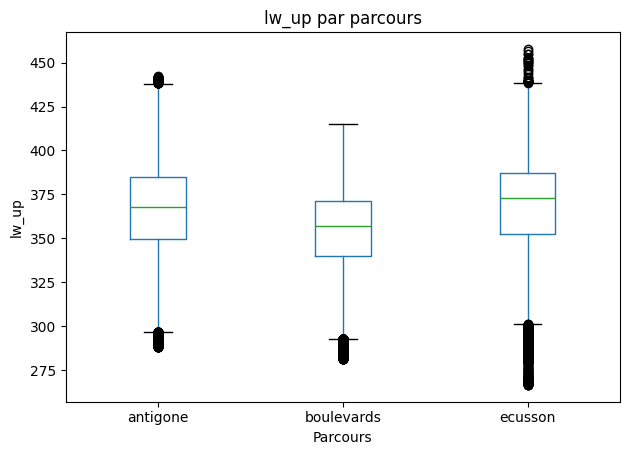

<Figure size 700x400 with 0 Axes>

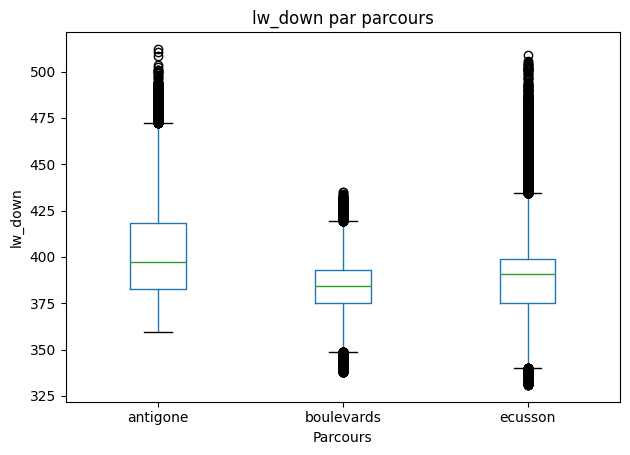

<Figure size 700x400 with 0 Axes>

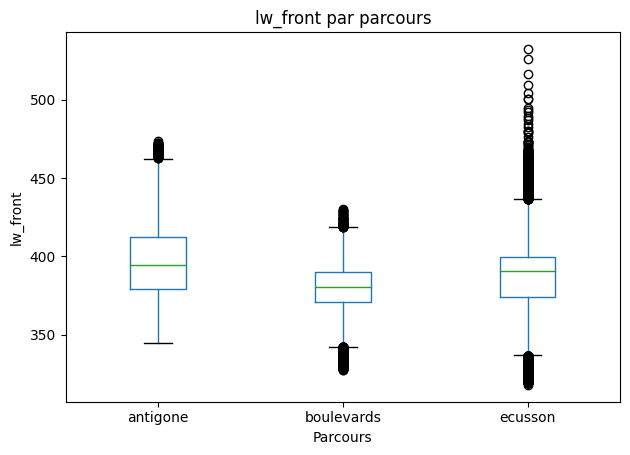

<Figure size 700x400 with 0 Axes>

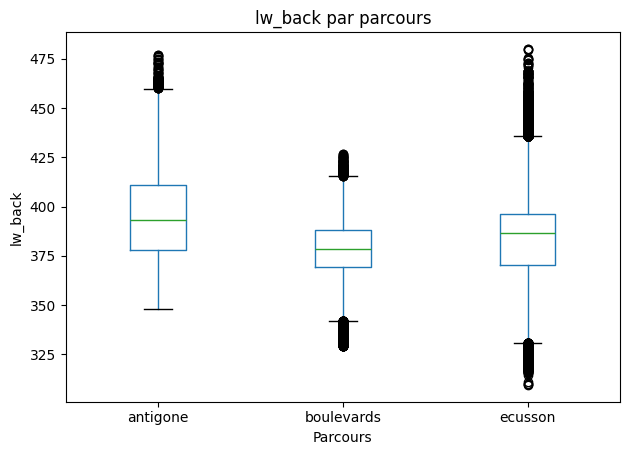

<Figure size 700x400 with 0 Axes>

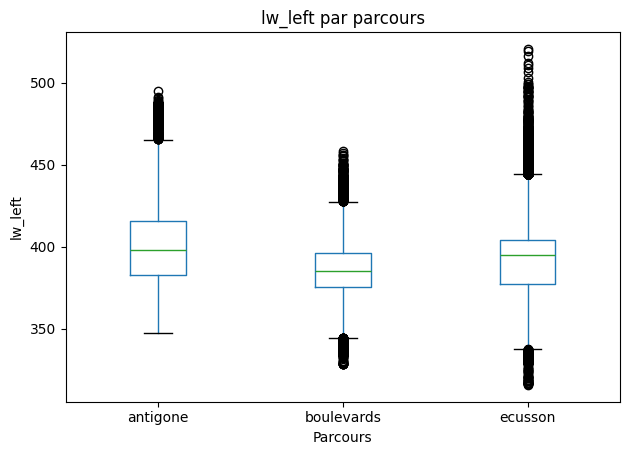

<Figure size 700x400 with 0 Axes>

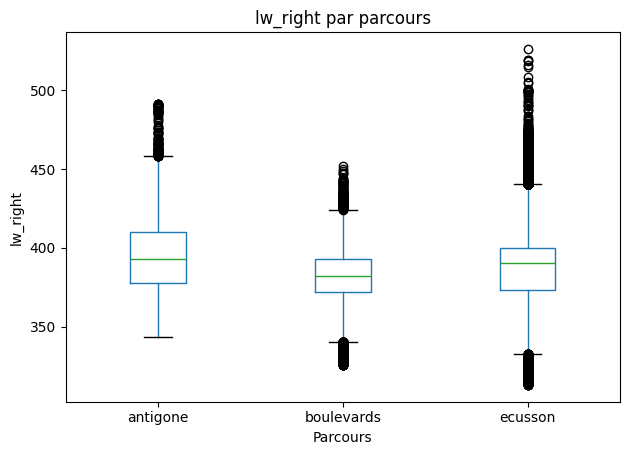

<Figure size 700x400 with 0 Axes>

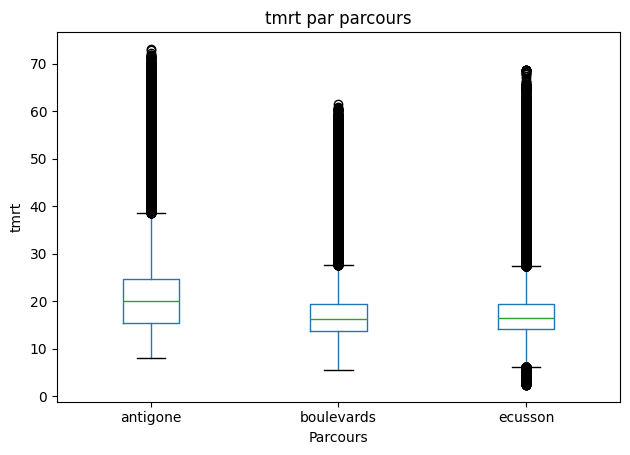

<Figure size 700x400 with 0 Axes>

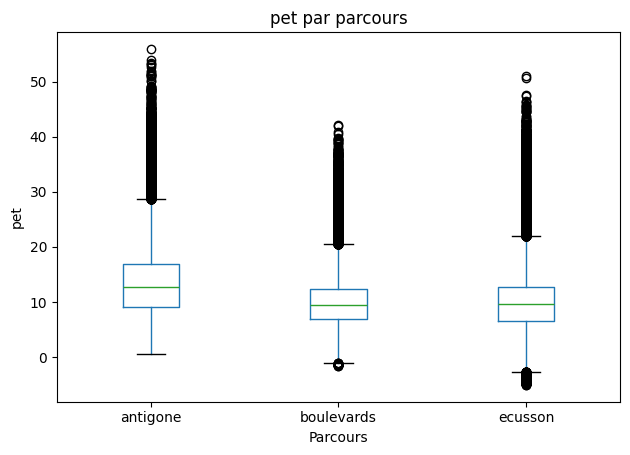

In [58]:
BOXPLOT = FIG_DIR / "boxplot"
create_folder(BOXPLOT)
for v in METEO:
    plt.figure(figsize=(7, 4))
    raw.boxplot(column=v, by="track_id", grid=False)
    plt.title(f"{v} par parcours")
    plt.suptitle("")
    plt.xlabel("Parcours")
    plt.ylabel(v)
    plt.tight_layout()
    
    # Sauvegarde du graphique
    plt.savefig(BOXPLOT / f"box_{v}_parcours.png", dpi=150)

## Distribution globale des variables météo

Ce bloc trace un **histogramme** pour chaque variable météo disponible, afin de visualiser la **répartition des valeurs mesurées** (et détecter d’éventuels biais ou valeurs extrêmes).

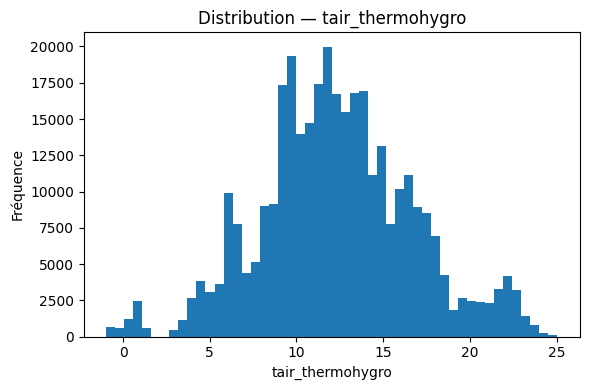

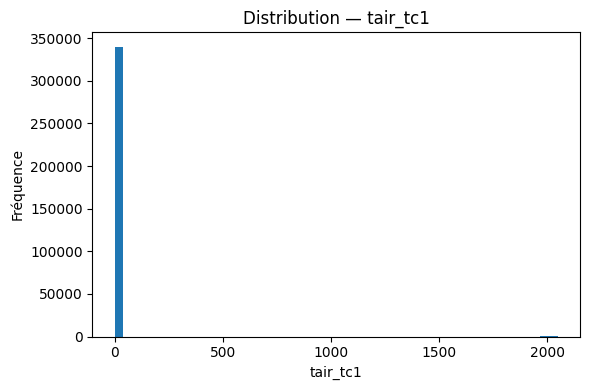

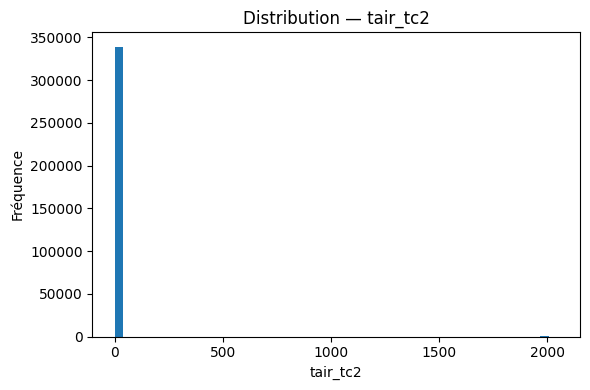

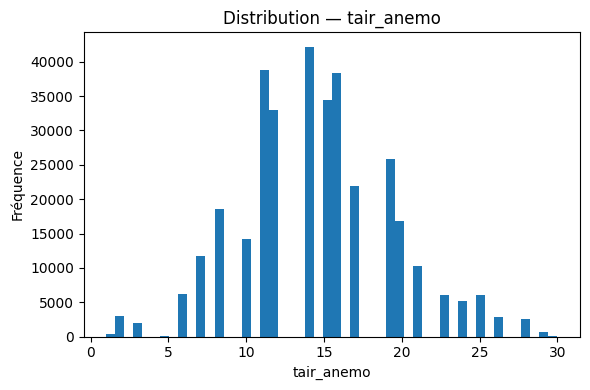

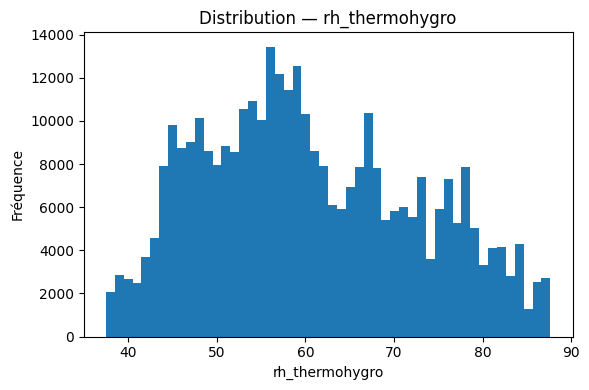

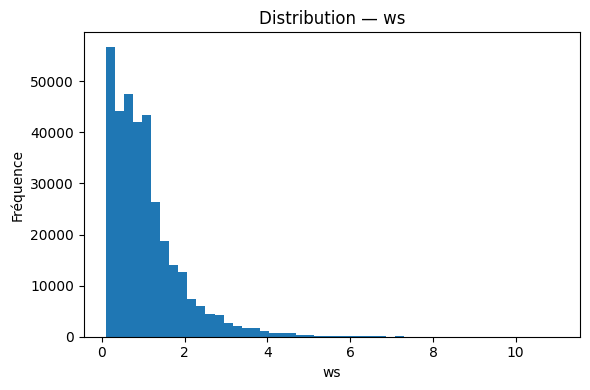

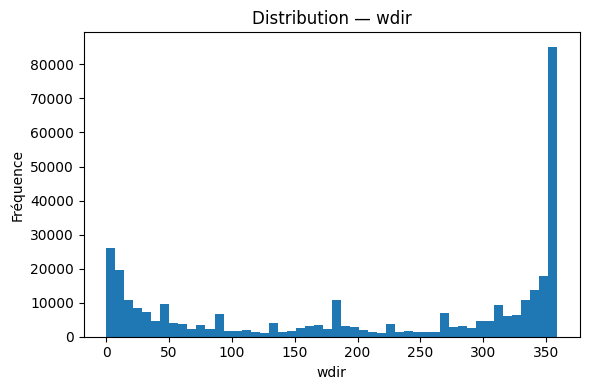

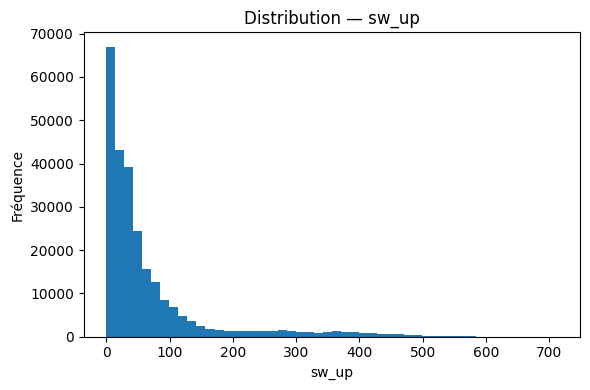

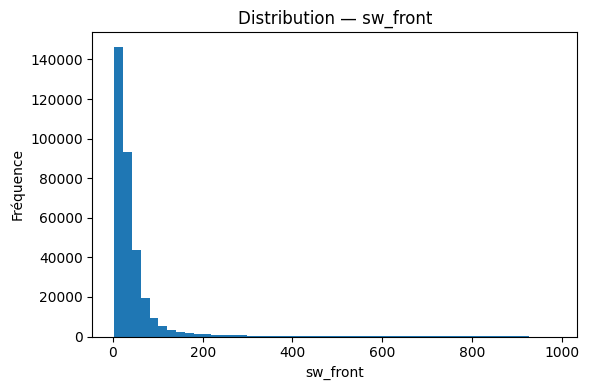

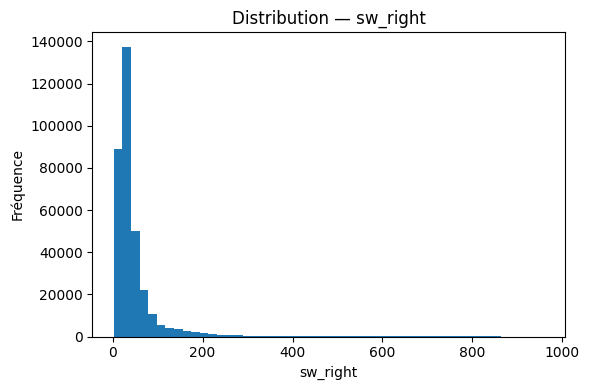

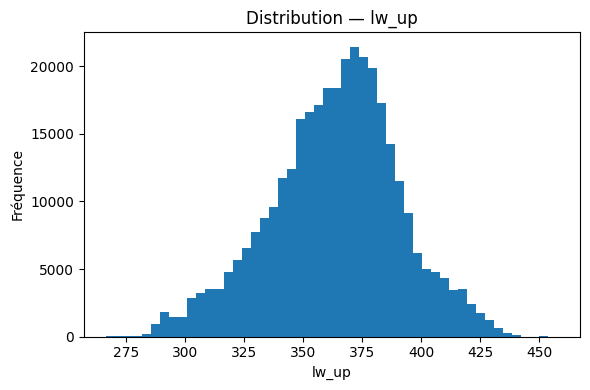

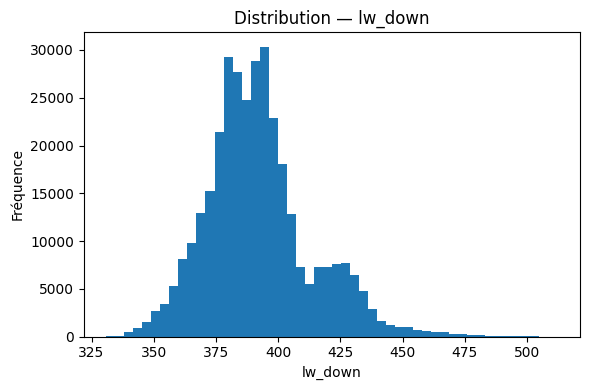

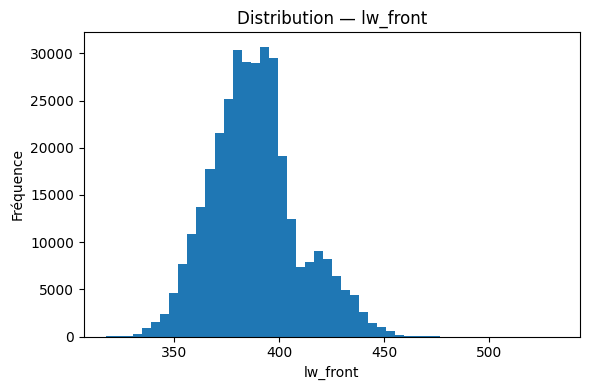

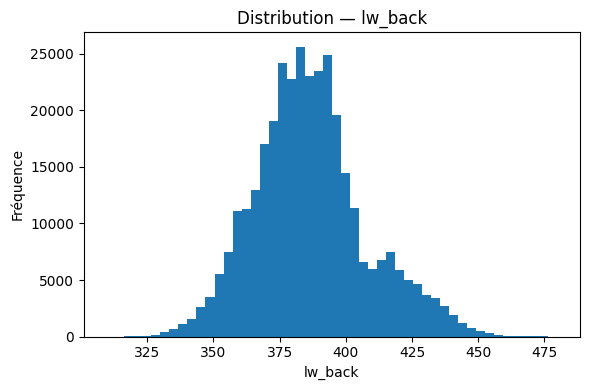

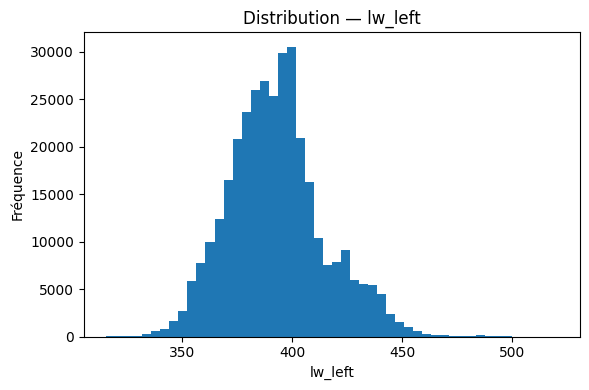

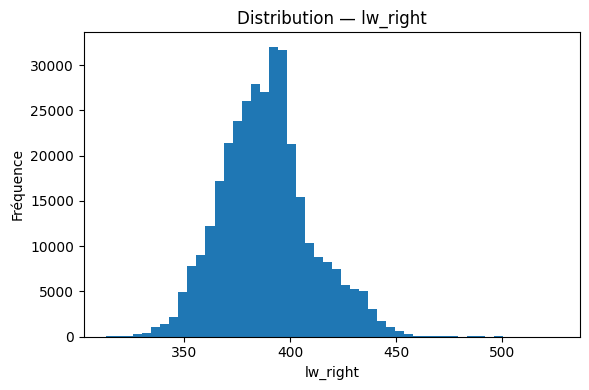

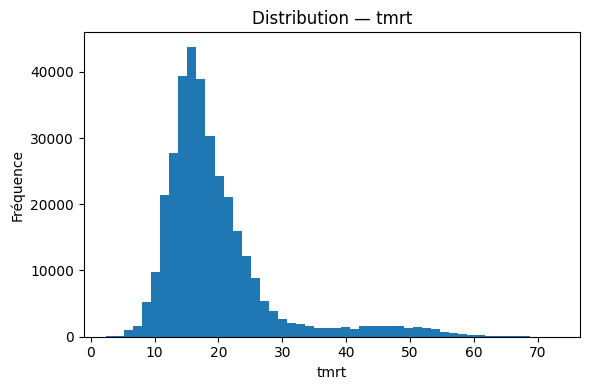

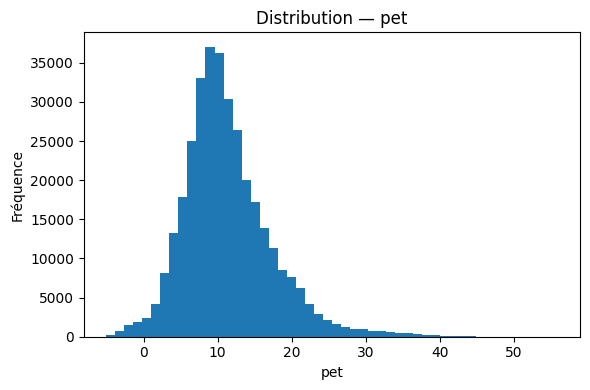

In [59]:
HIST = COMPT / "histogramme"
create_folder(HIST)
for v in METEO:
    s = raw[v].dropna()
    if len(s) == 0:
        continue

    plt.figure(figsize=(6, 4))
    plt.hist(s, bins=50)
    plt.title(f"Distribution — {v}")
    plt.xlabel(v)
    plt.ylabel("Fréquence")
    plt.tight_layout()

    # Sauvegarde et affichage
    plt.savefig(HIST / f"dist_global_{v}.png", dpi=150)

## Moyennes et intervalles de confiance (IC95%) par parcours

Ce bloc calcule la **moyenne** et l’**intervalle de confiance à 95 %** pour chaque variable météo et chaque parcours (`track_id`).  
Les résultats sont visualisés sous forme de points avec barres d’erreur.

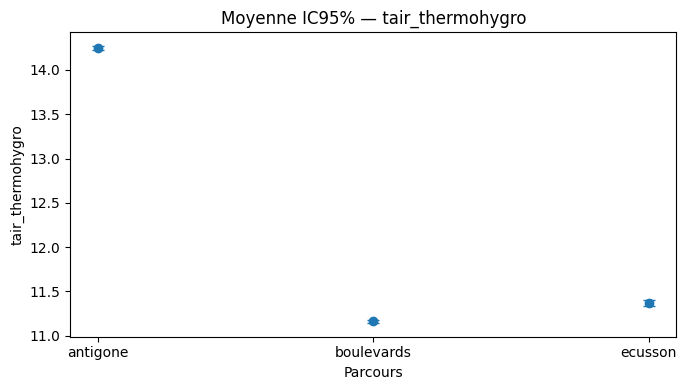

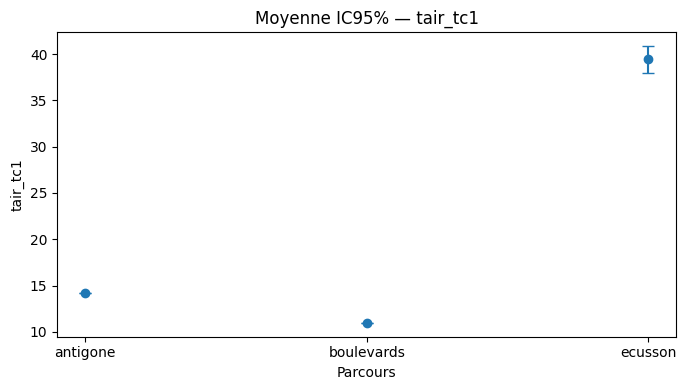

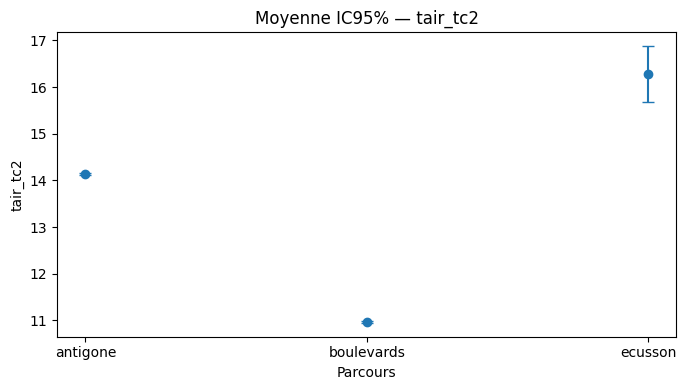

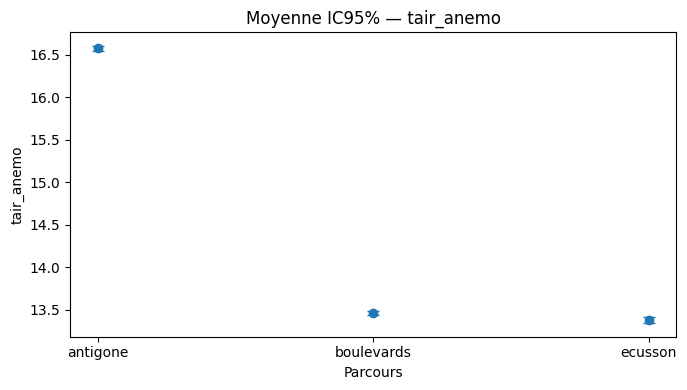

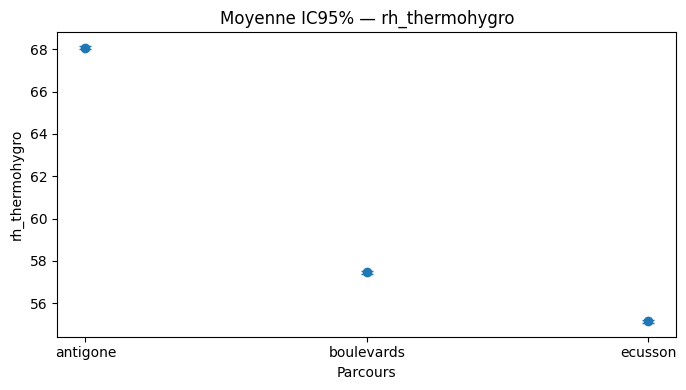

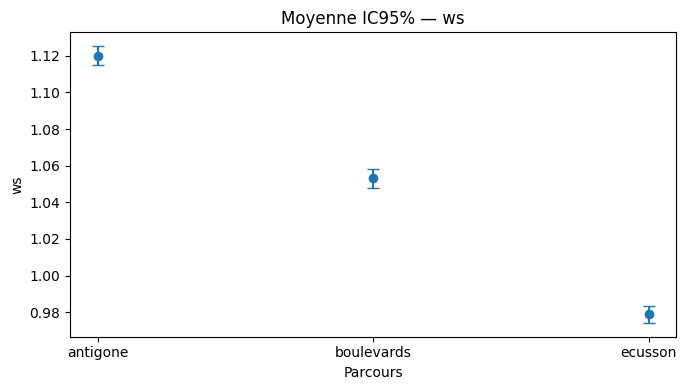

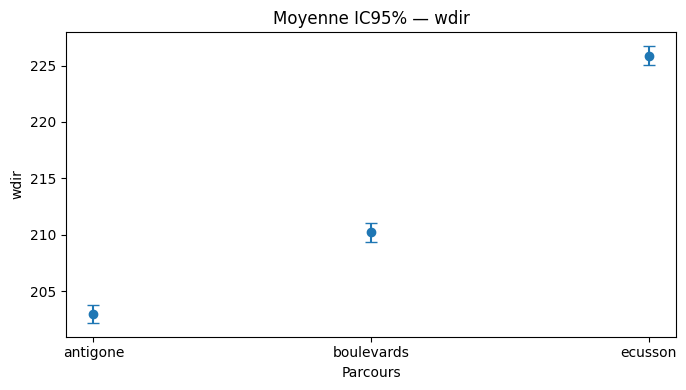

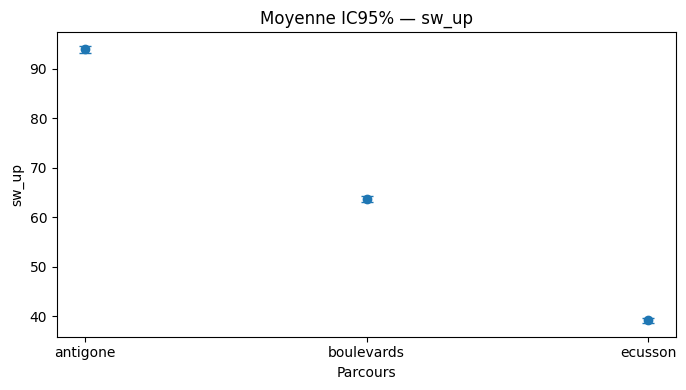

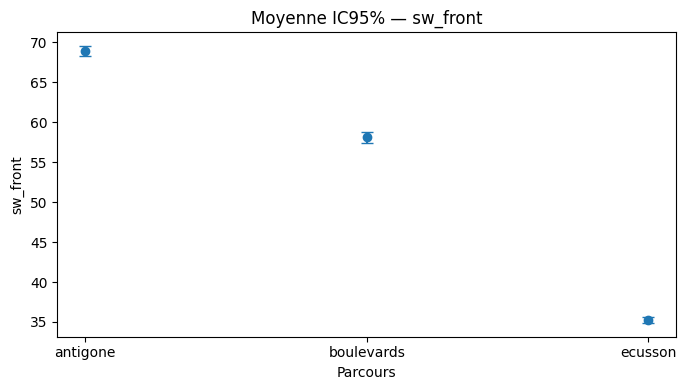

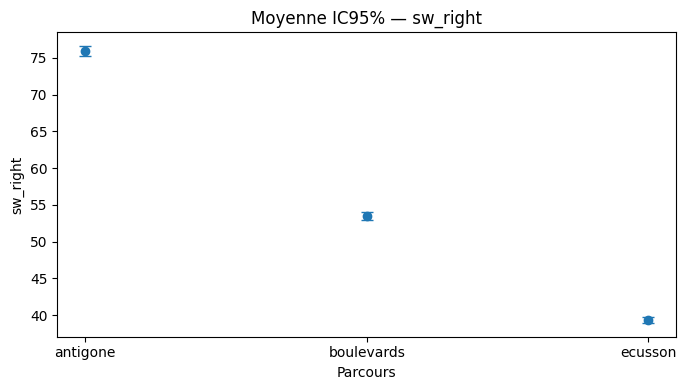

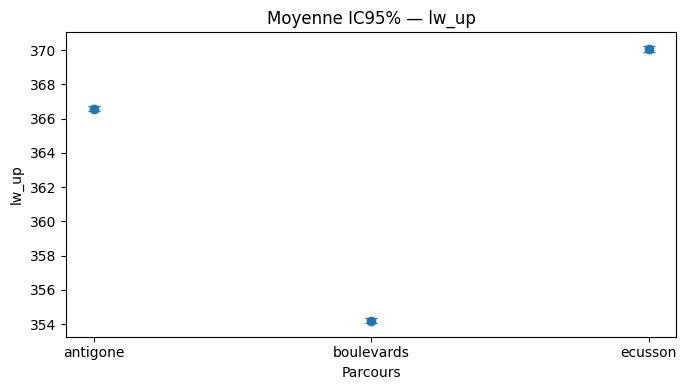

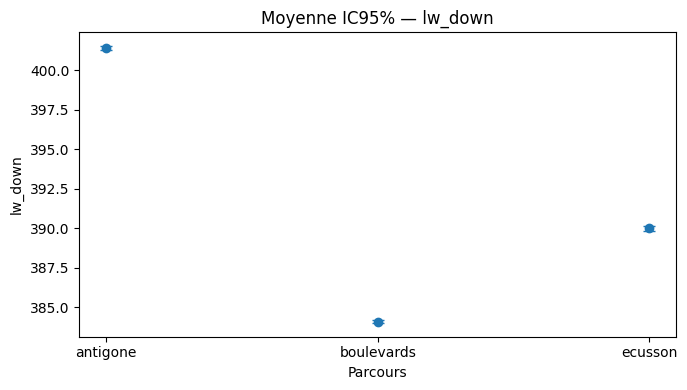

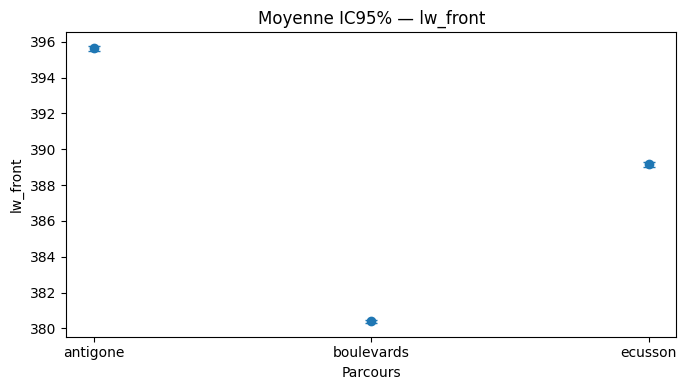

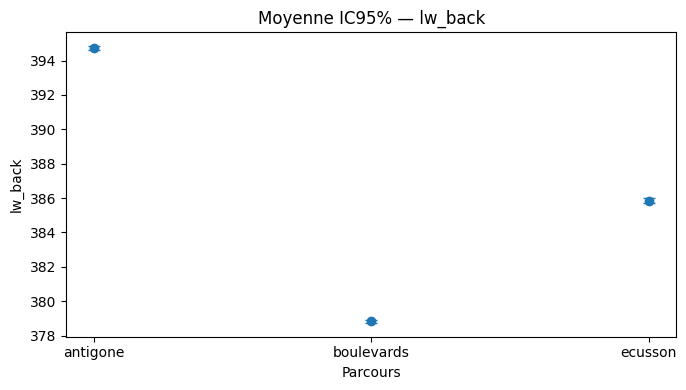

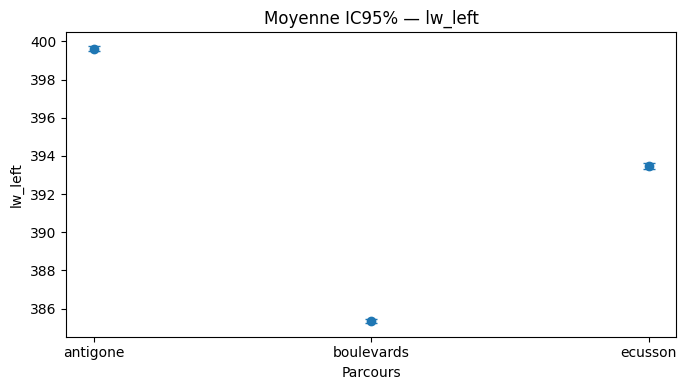

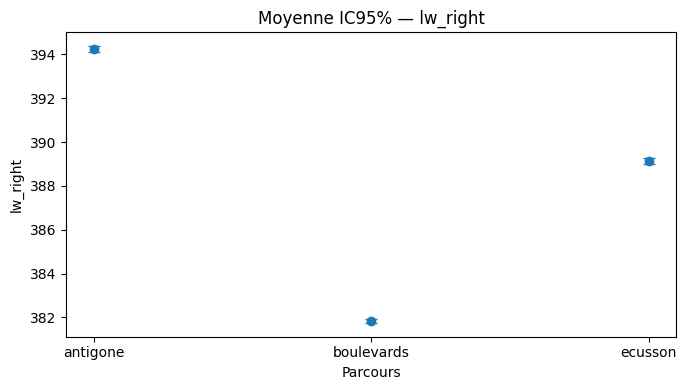

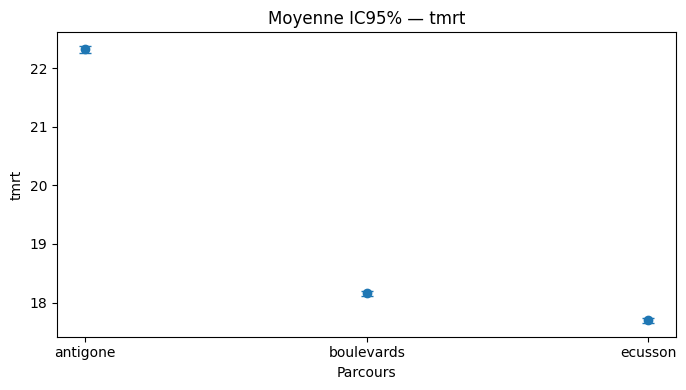

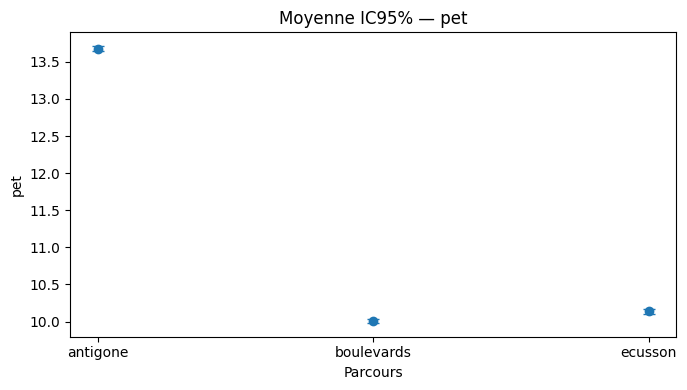

In [60]:
IC = FIG_DIR / "ic95%"
create_folder(IC)

# Calcul des moyennes, écarts-types et effectifs par parcours
g = raw.groupby("track_id")[METEO].agg(["mean", "std", "count"])

# Tracé des moyennes avec intervalles de confiance
for v in METEO:
    m = g[(v, "mean")]
    se = g[(v, "std")] / np.sqrt(g[(v, "count")])
    ic = 1.96 * se  # Intervalle de confiance à 95 %

    plt.figure(figsize=(7, 4))
    plt.errorbar(m.index.astype(str), m.values, yerr=ic.values, fmt="o", capsize=4)
    plt.title(f"Moyenne IC95% — {v}")
    plt.xlabel("Parcours")
    plt.ylabel(v)
    plt.tight_layout()

    # Sauvegarde et affichage
    plt.savefig(IC / f"ic_{v}_parcours.png", dpi=150)

##  Profil des variables météo selon le moment de la journée (M1–M4)

Ce bloc trace, pour chaque variable météo et pour les parcours principaux (**Antigone**, **Boulevards**, **Écusson**), l’évolution moyenne des valeurs selon les quatre créneaux horaires de mesure (`M1` à `M4`).

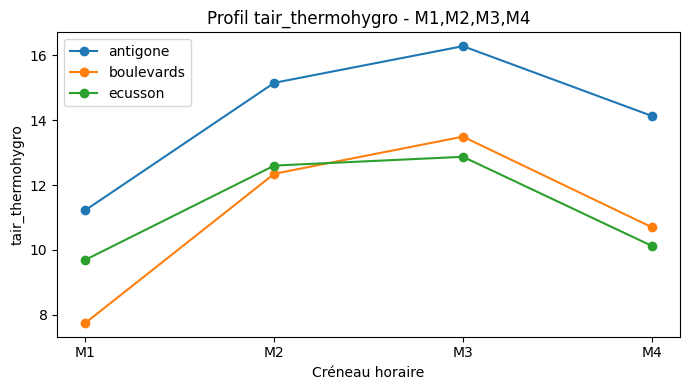

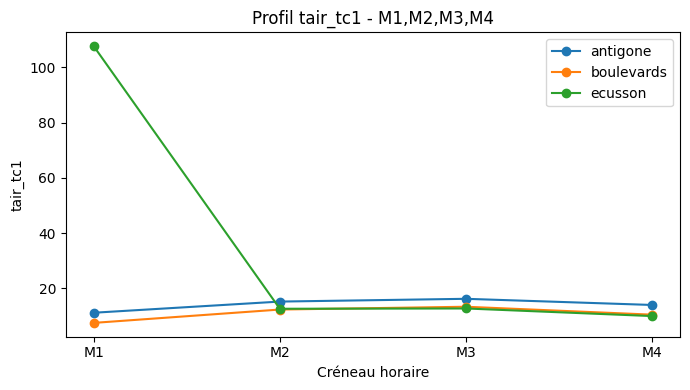

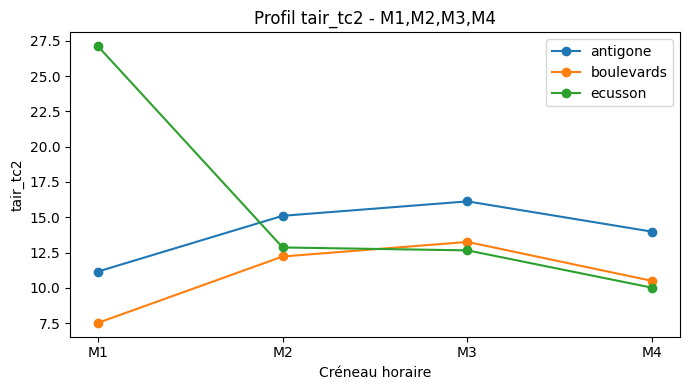

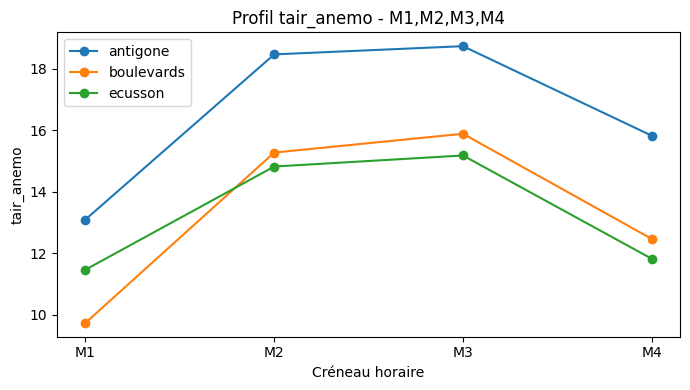

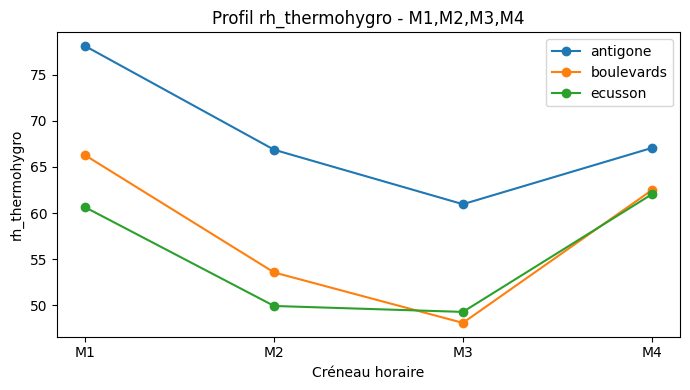

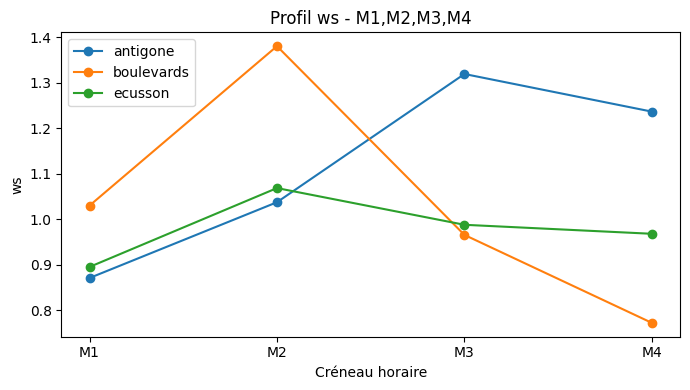

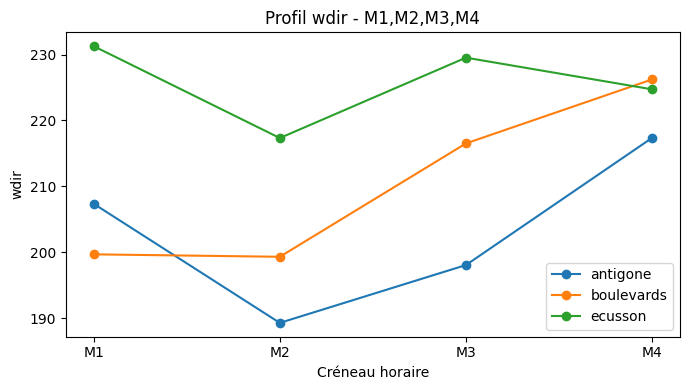

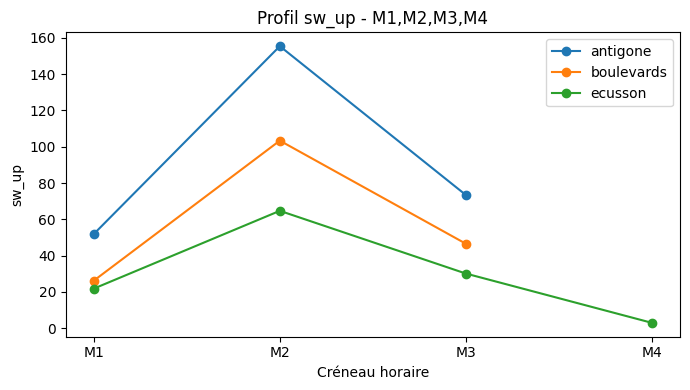

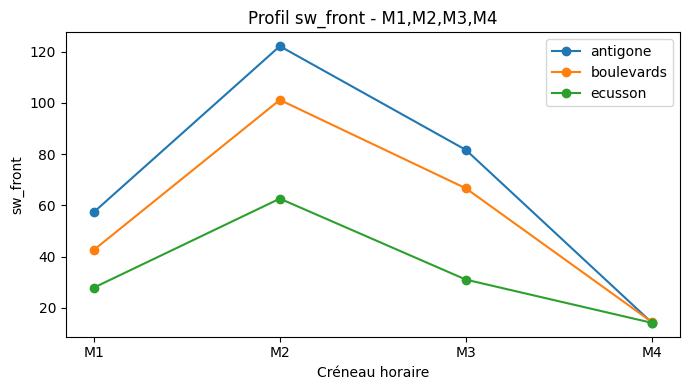

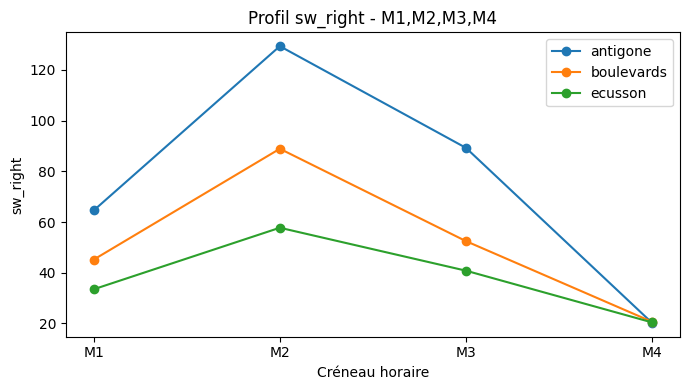

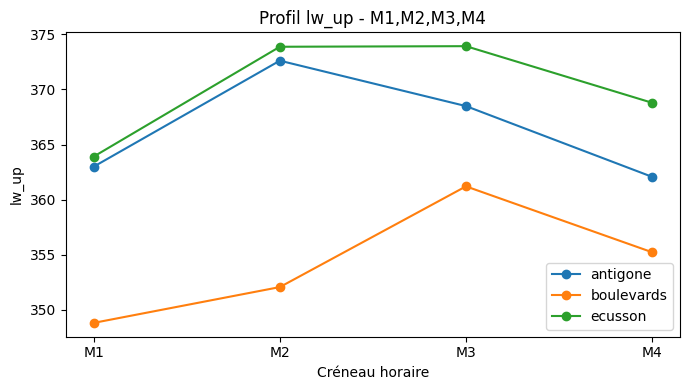

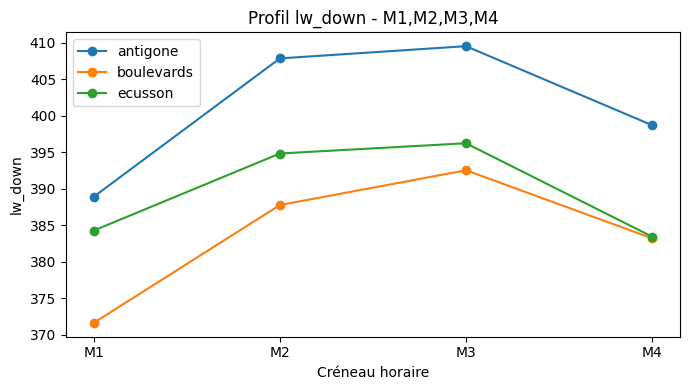

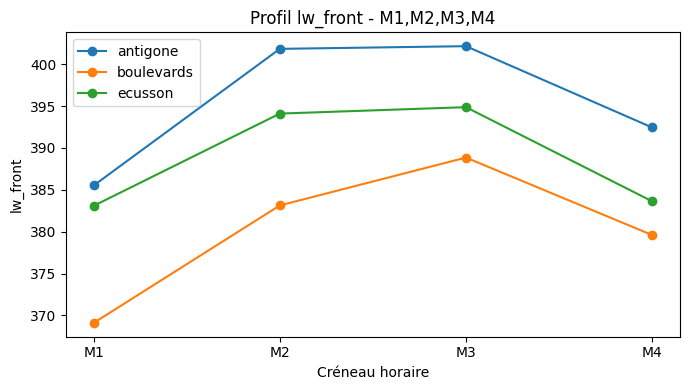

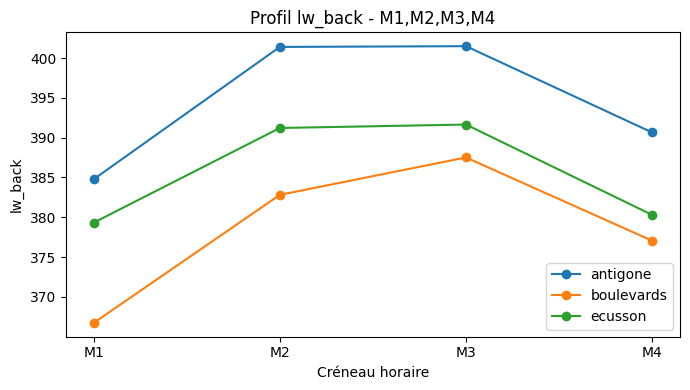

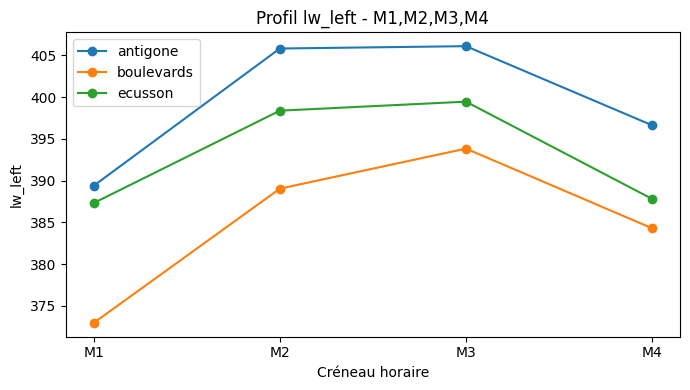

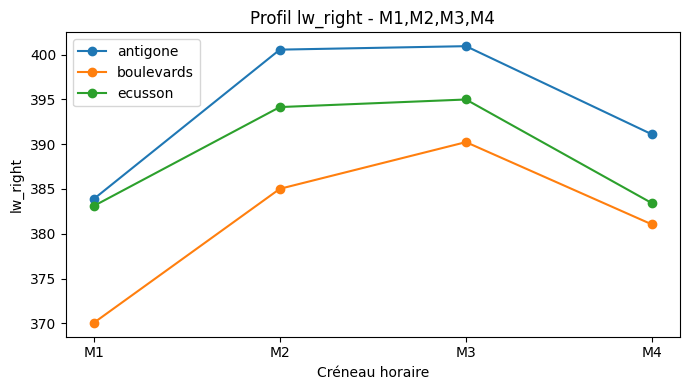

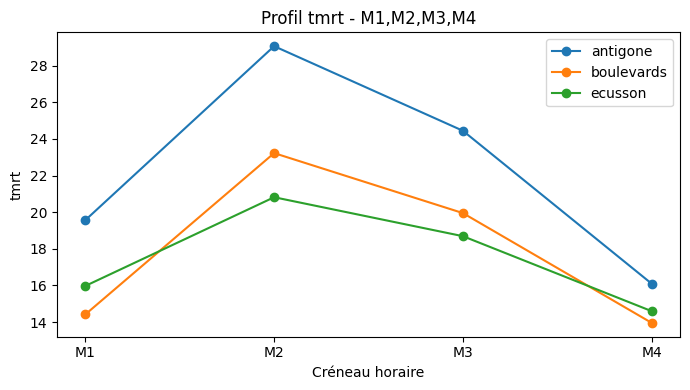

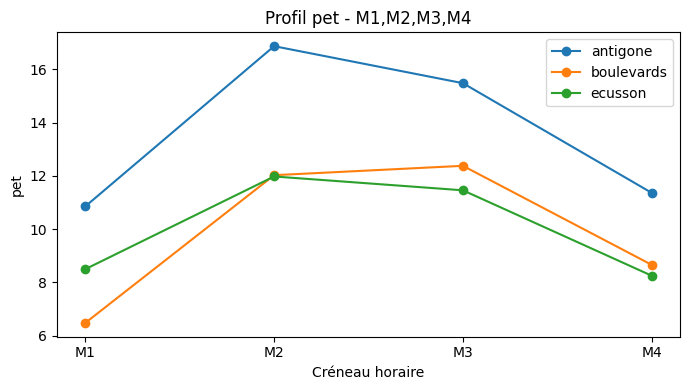

In [61]:
PROFIL = FIG_DIR / "profil"
create_folder(PROFIL)

# Ordre des créneaux horaires
order = ["M1", "M2", "M3", "M4"]

# Moyenne des variables par parcours et créneau
agg = raw.groupby(["track_id", "M_slot"])[METEO].mean().reset_index()

# Parcours à comparer
tracks_focus = ["antigone", "boulevards", "ecusson"]

# Tracé des profils journaliers
for v in METEO:
    plt.figure(figsize=(7, 4))
    for t in tracks_focus:
        gg = agg[agg.track_id == t].set_index("M_slot").reindex(order)[v]
        if gg.isna().all():
            continue
        plt.plot(order, gg.values, marker="o", label=t)
    
    plt.title(f"Profil {v} - M1,M2,M3,M4")
    plt.xlabel("Créneau horaire")
    plt.ylabel(v)
    plt.legend()
    plt.tight_layout()

    # Sauvegarde et affichage
    plt.savefig(PROFIL / "profil_{v}_Mslots.png", dpi=150)

## Moyenne des variables météo par parcours

Ce bloc compare la **moyenne des variables météorologiques** principales entre les trois parcours étudiés : **Antigone**, **Boulevards** et **Écusson**.Les résultats sont présentés sous forme d’histogrammes.

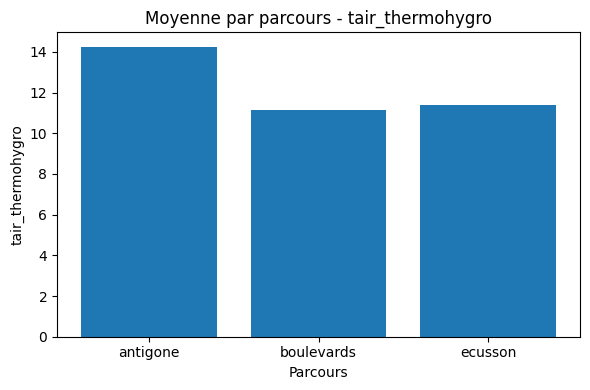

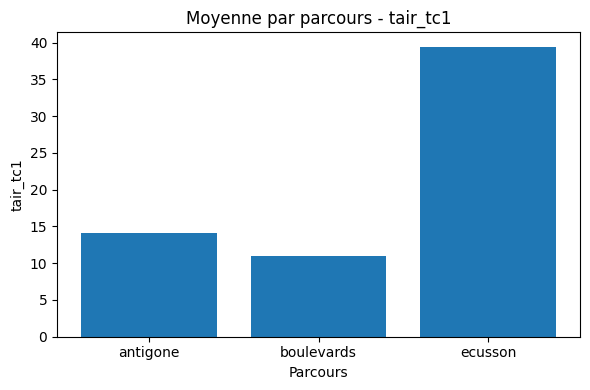

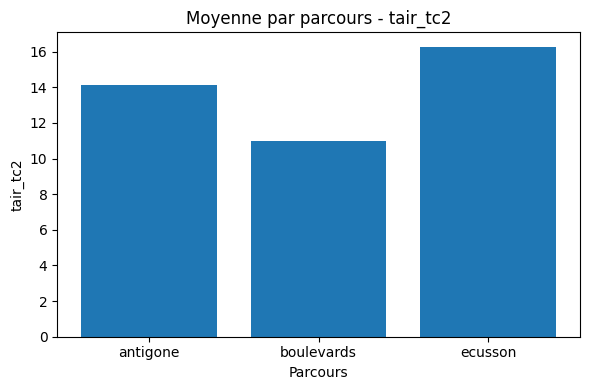

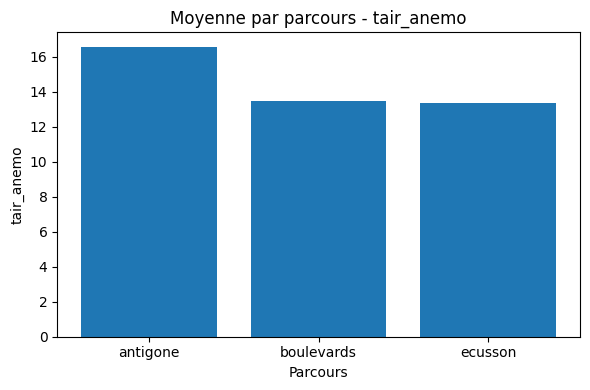

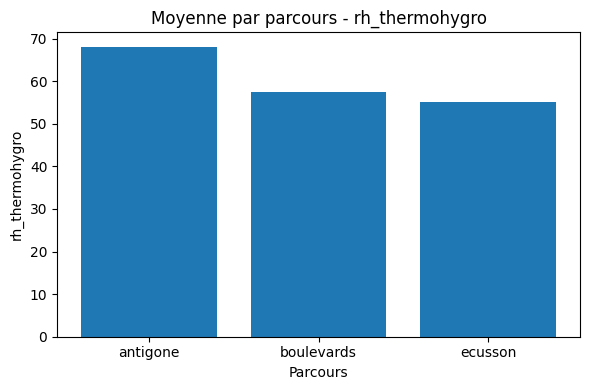

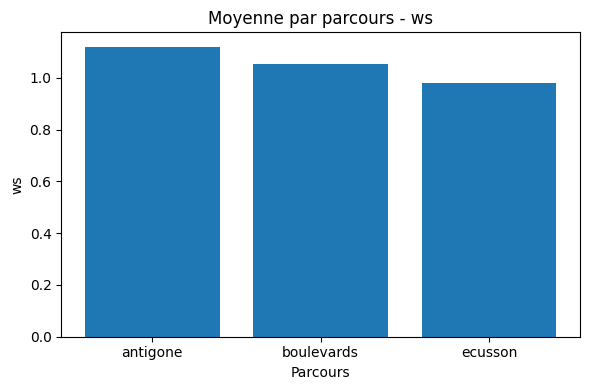

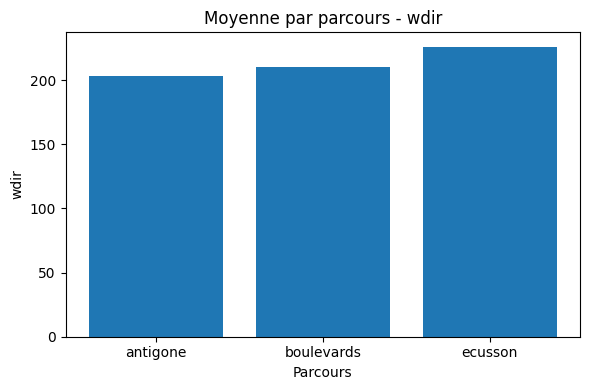

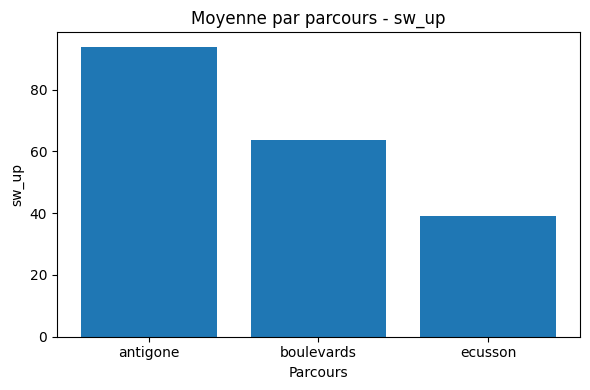

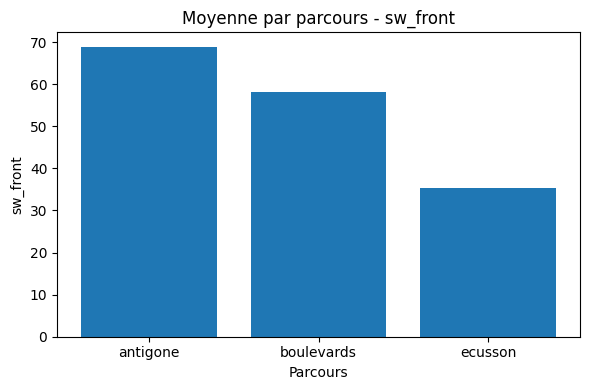

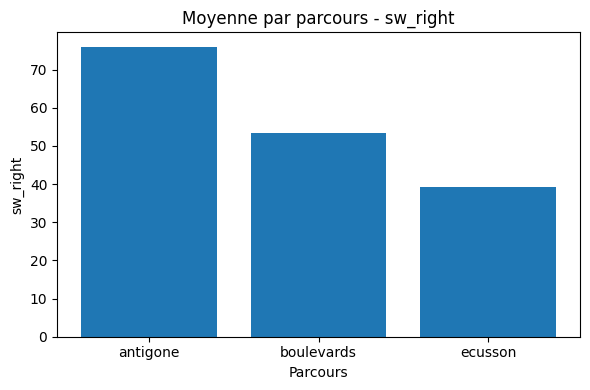

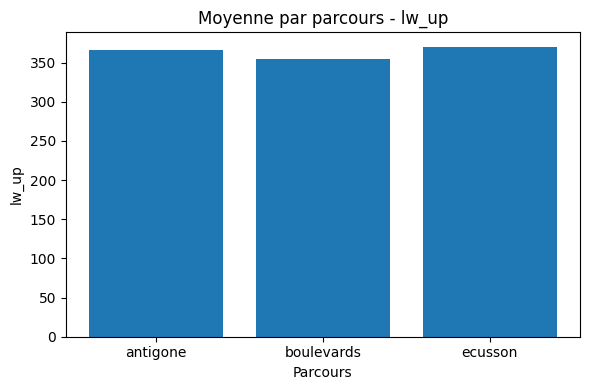

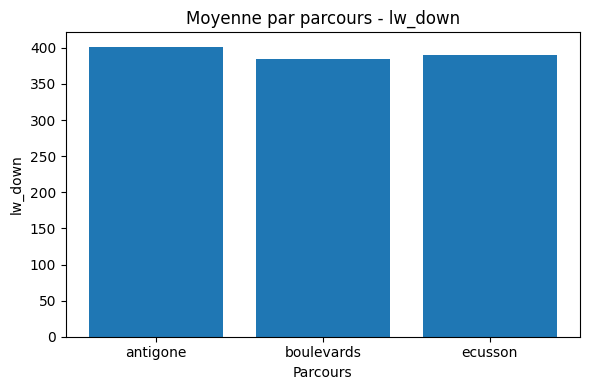

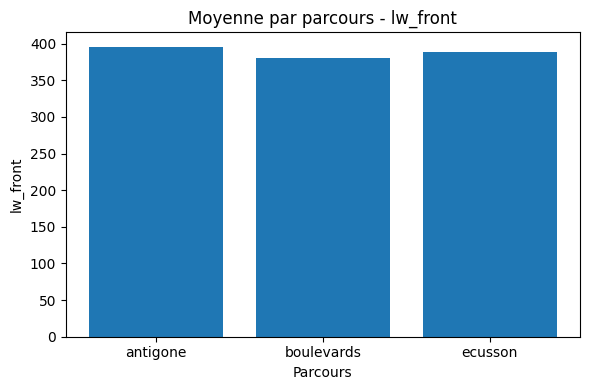

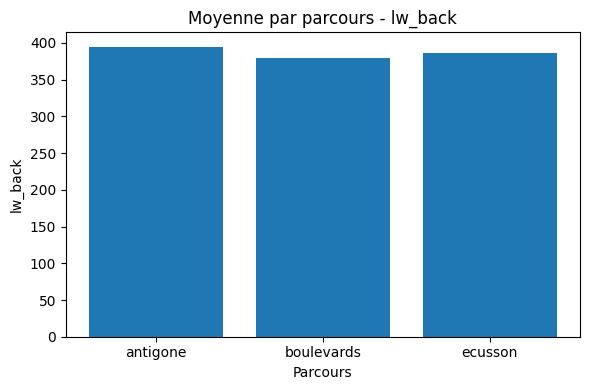

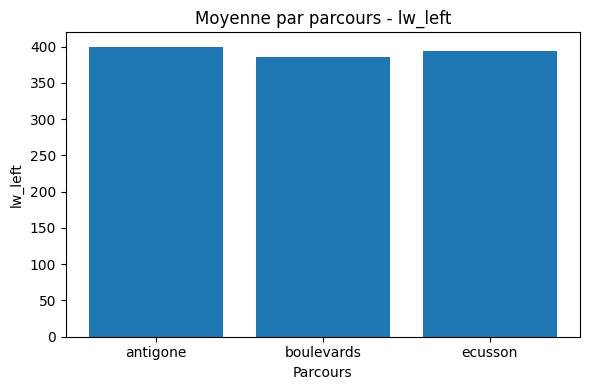

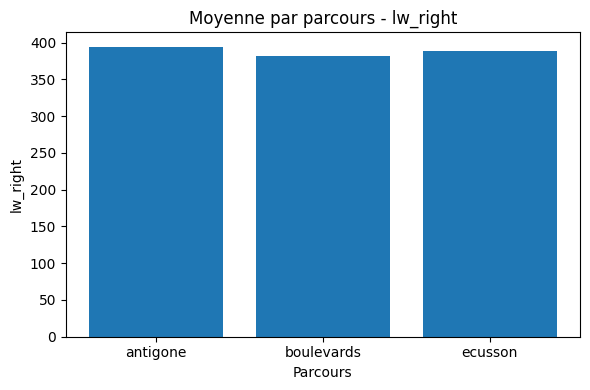

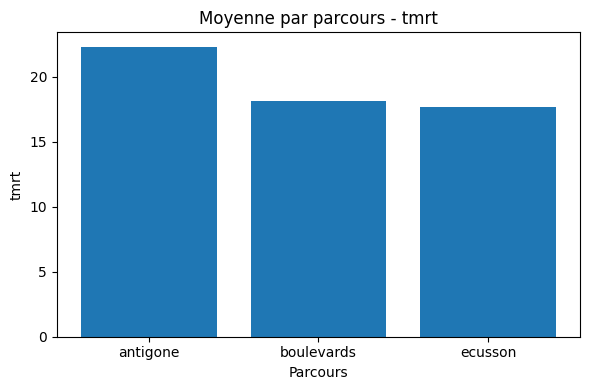

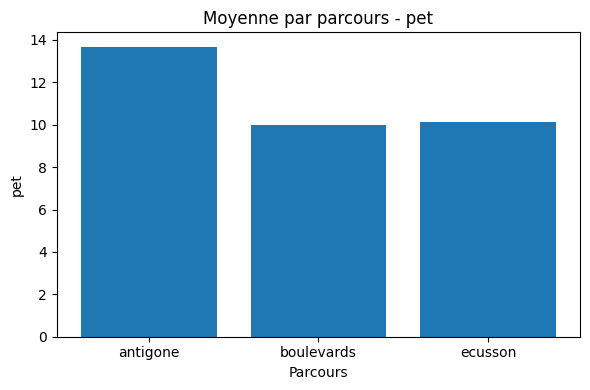

In [62]:
BARMEAN = FIG_DIR / "bar_mean"
create_folder(BARMEAN)
# Sélection des parcours d'intérêt et calcul des moyennes
comp = (raw[raw["track_id"].isin(["antigone", "boulevards", "ecusson"])]
          .groupby("track_id")[METEO]
          .mean()
          .T)

# Tracé des moyennes par variable
for v in comp.index:
    plt.figure(figsize=(6, 4))
    plt.bar(comp.columns.astype(str), comp.loc[v].values)
    plt.title(f"Moyenne par parcours - {v}")
    plt.xlabel("Parcours")
    plt.ylabel(v)
    plt.tight_layout()

    # Sauvegarde et affichage
    plt.savefig(BARMEAN / f"bar_mean_{v}_parcours.png", dpi=150)

##  Visualisation spatiale de la température de l’air

Ce bloc trace la **position GPS** des points de mesure (`lon`, `lat`) et colore les points selon la variable pour chaque parcours. Cela permet de visualiser les variations de température le long du trajet.

C:\Users\antoc\AppData\Local\Temp\ipykernel_21296\1957459196.py:23: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(6, 6))


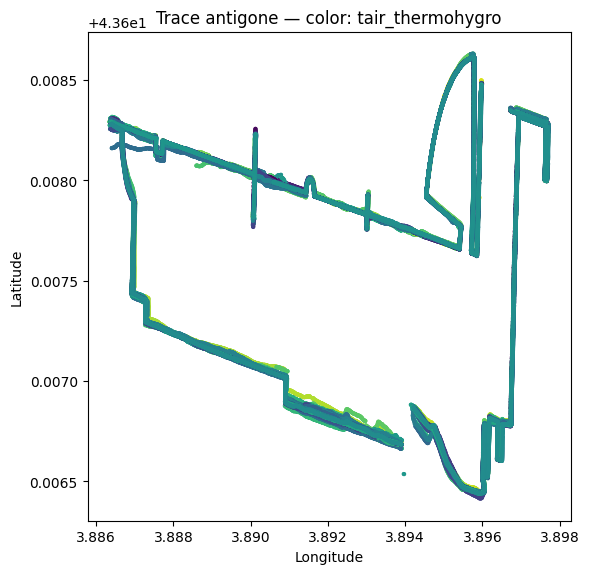

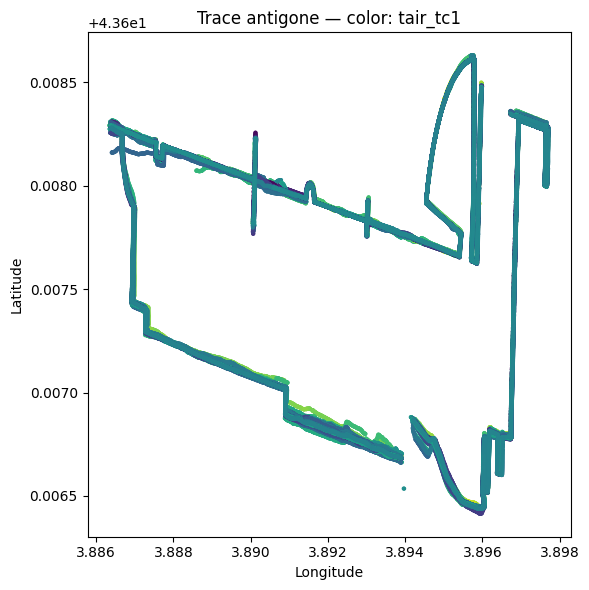

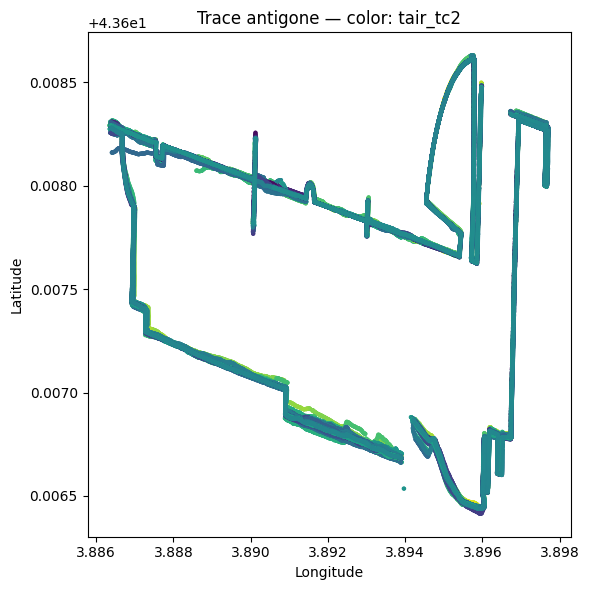

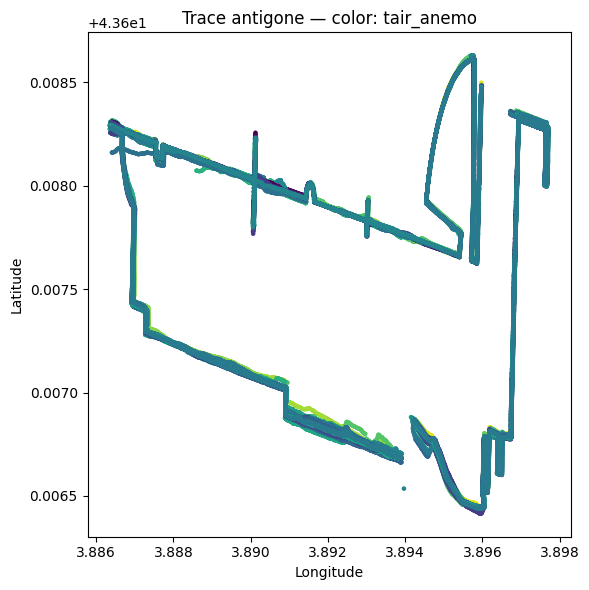

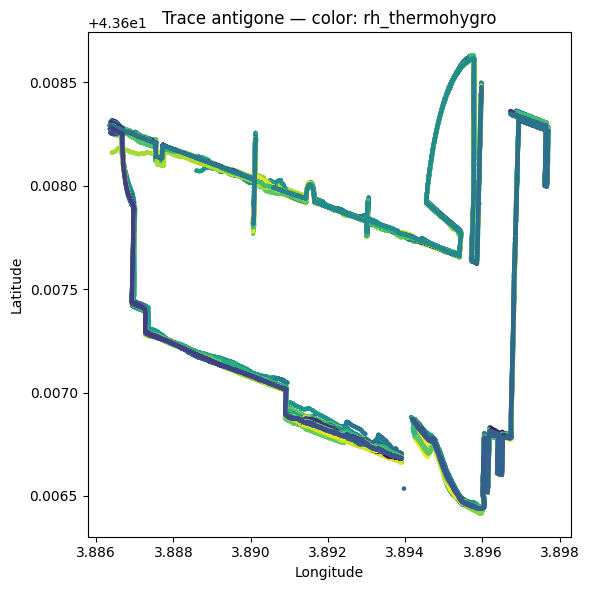

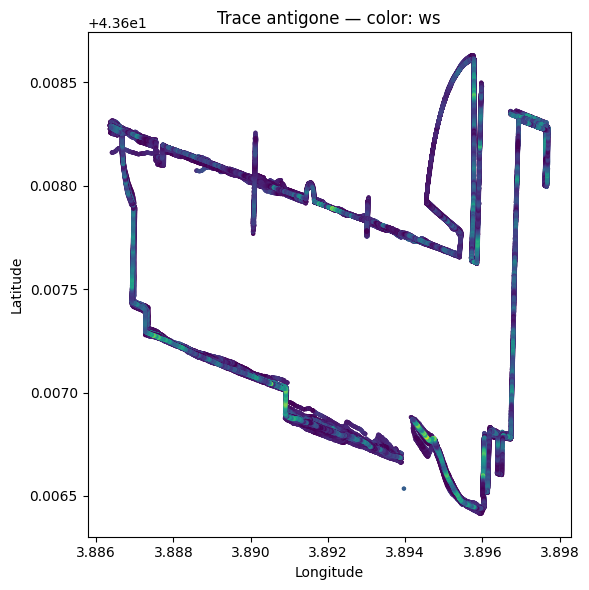

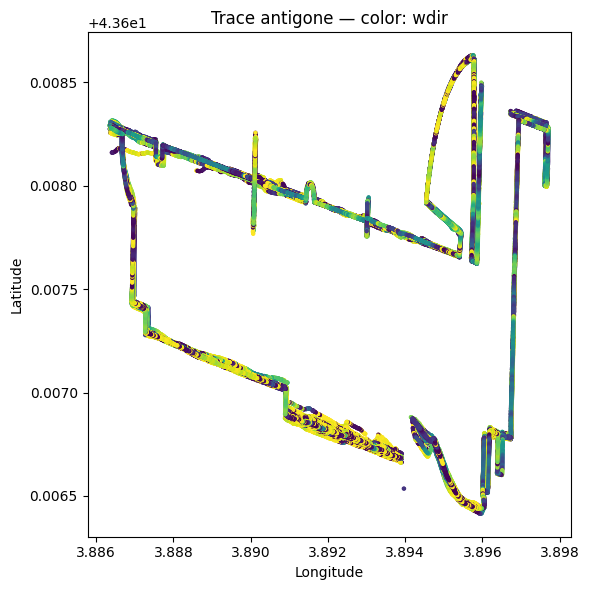

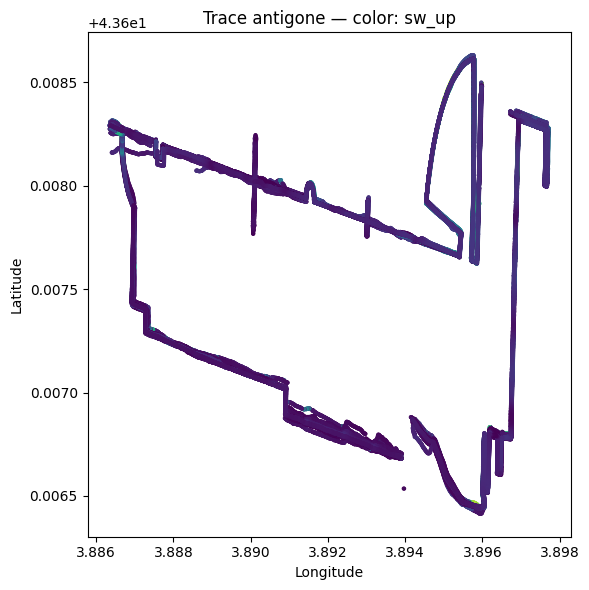

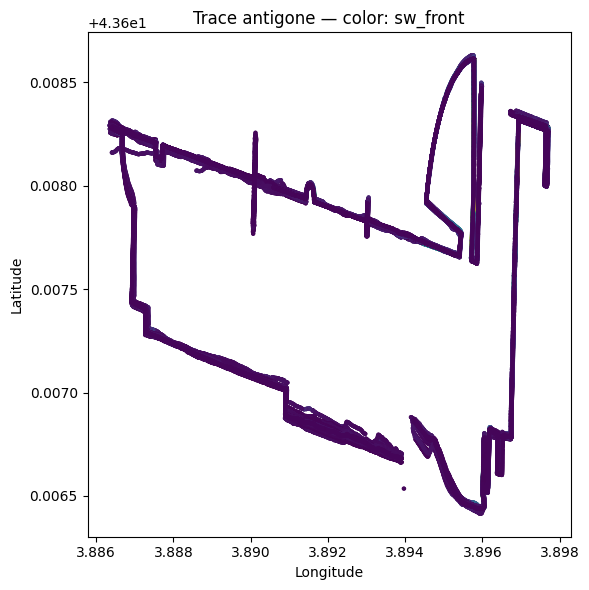

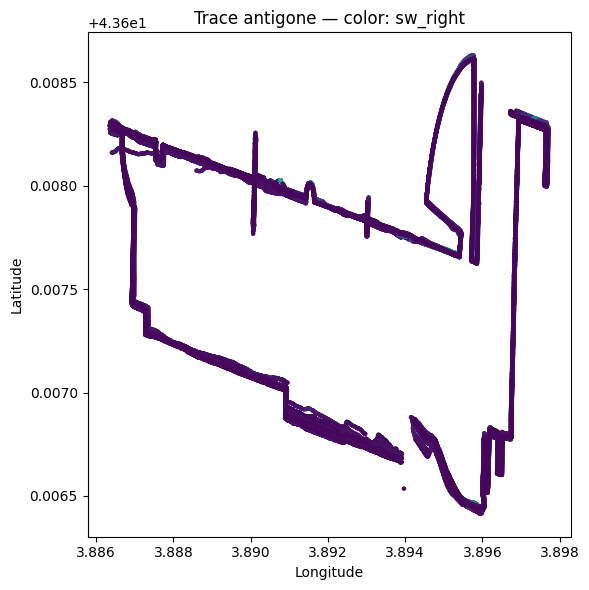

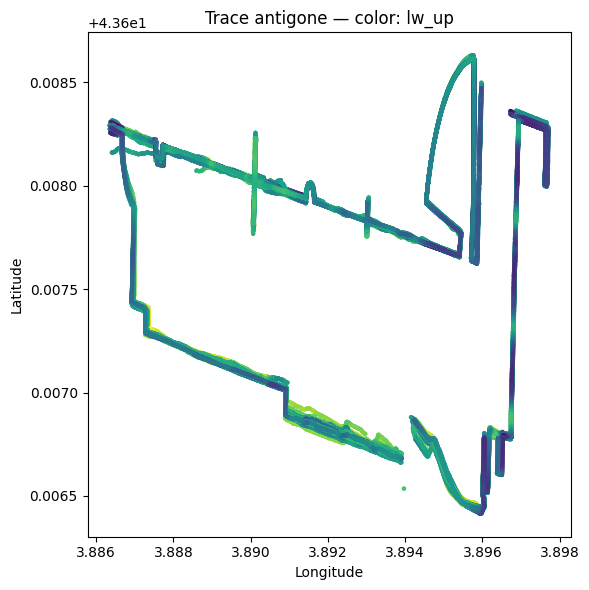

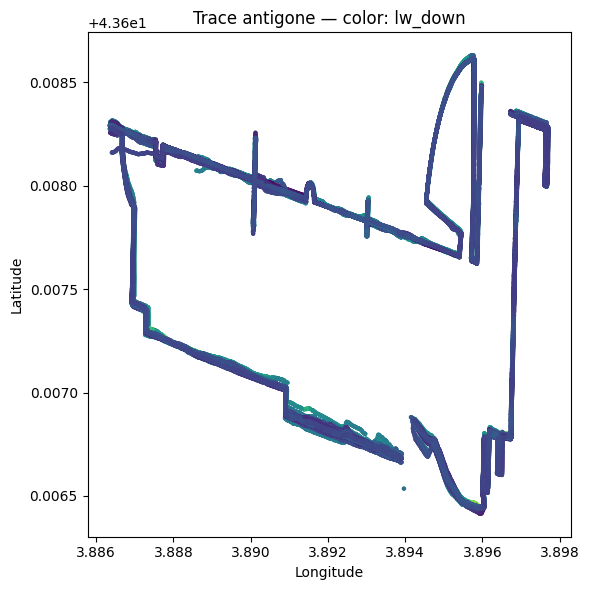

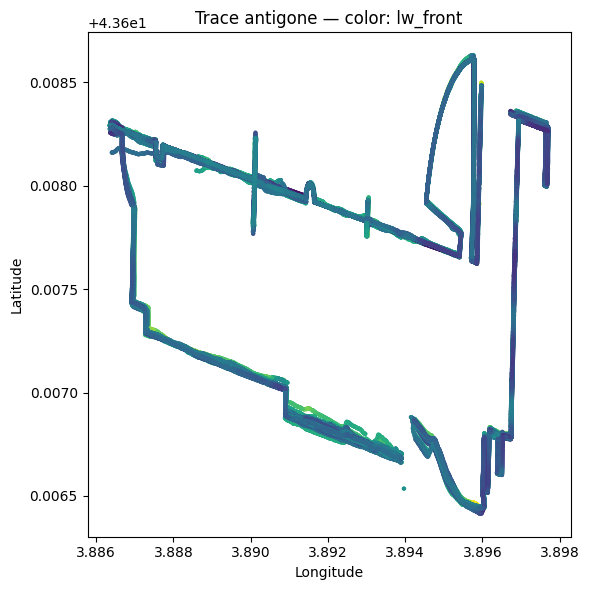

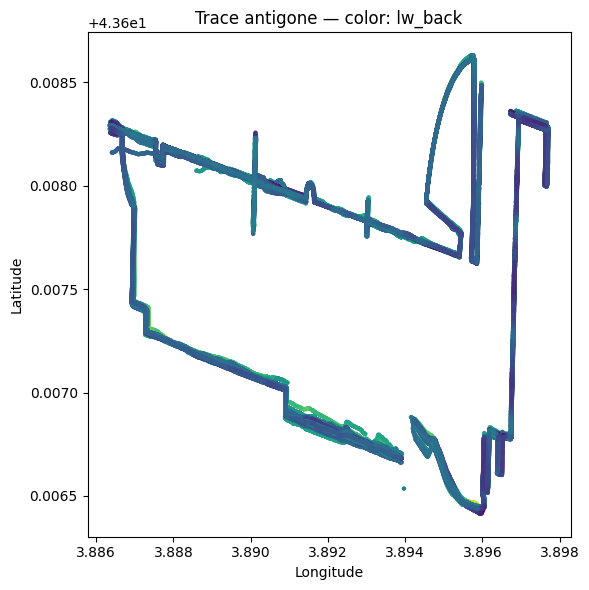

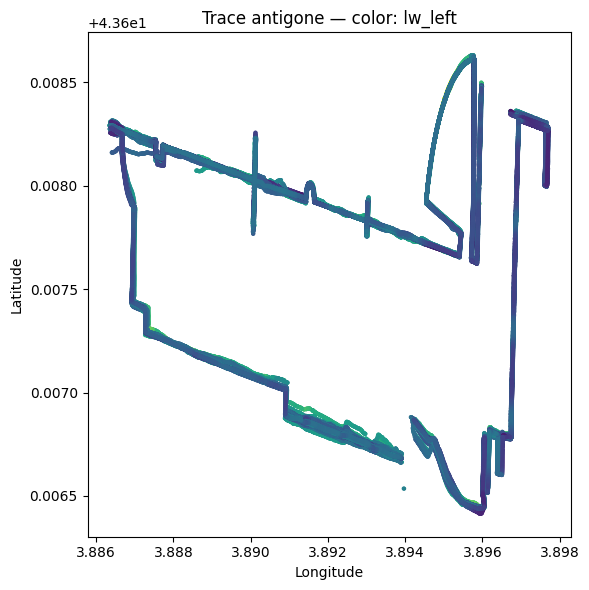

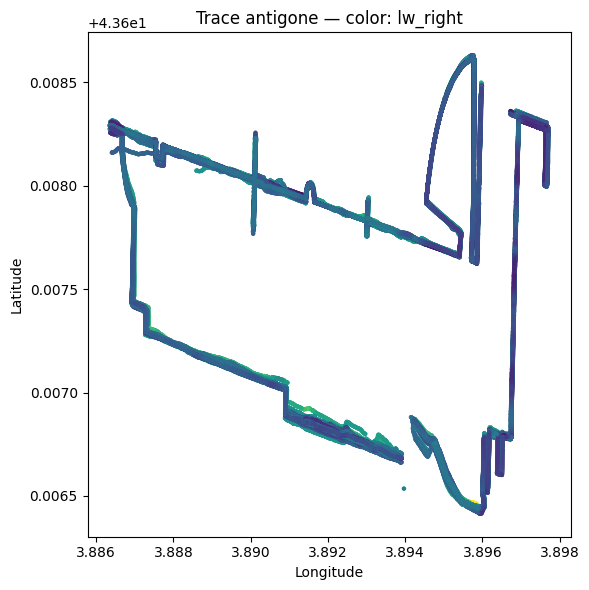

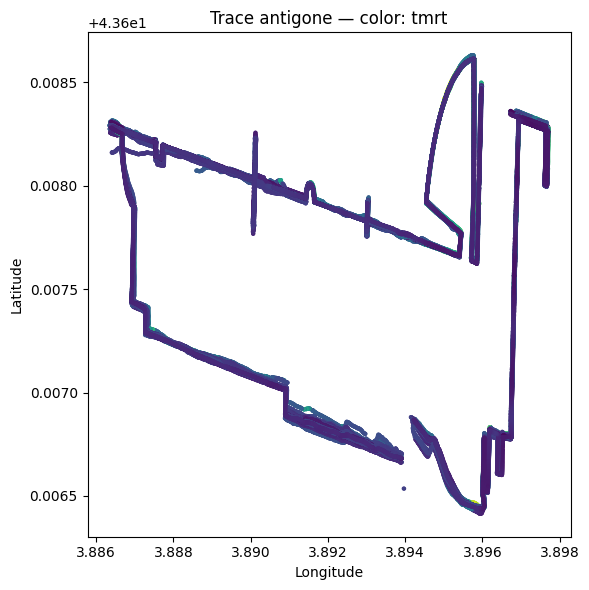

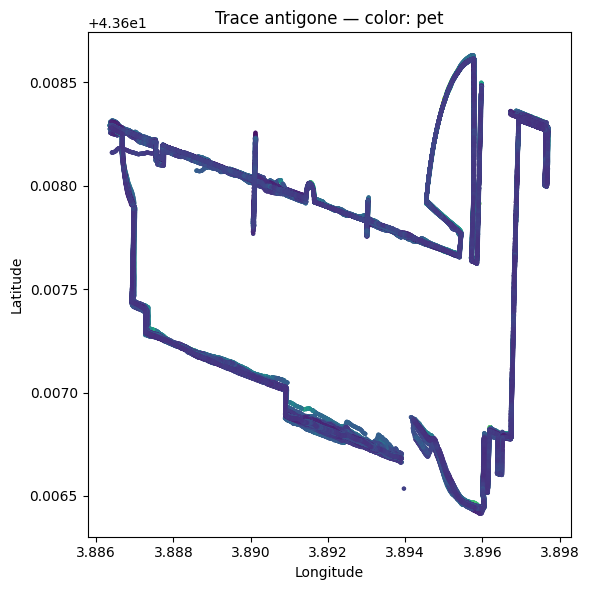

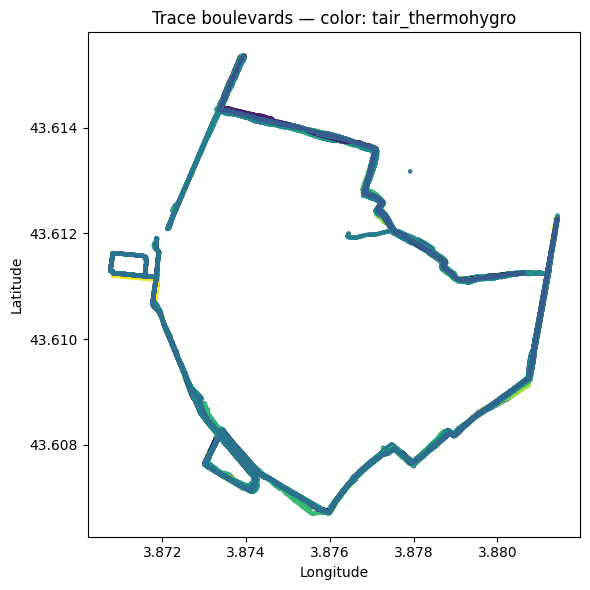

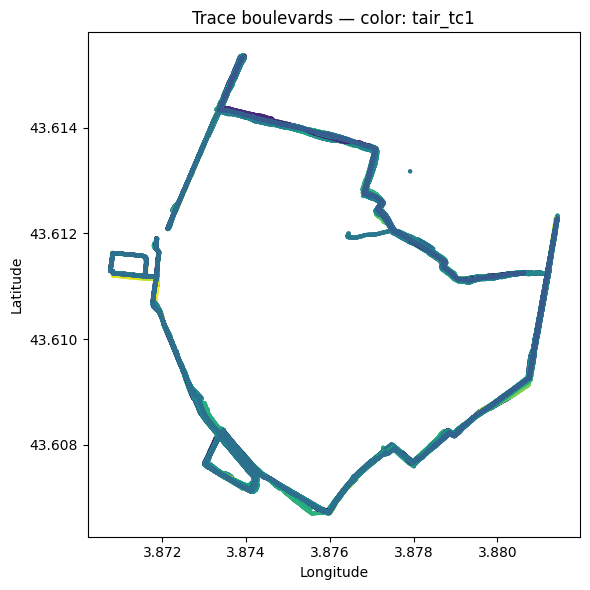

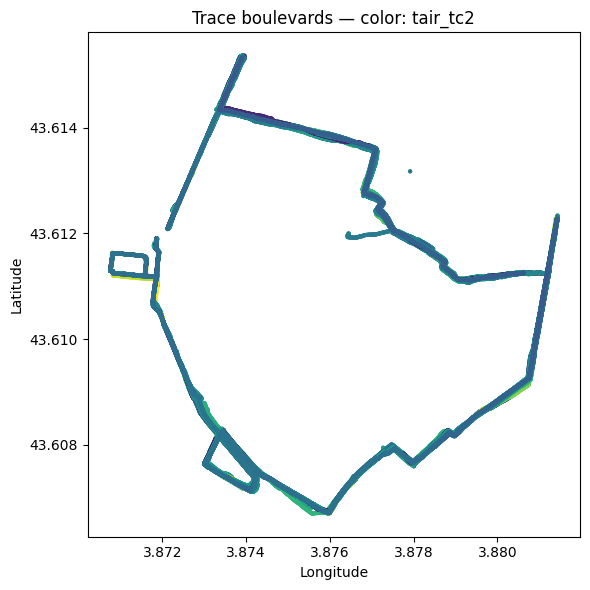

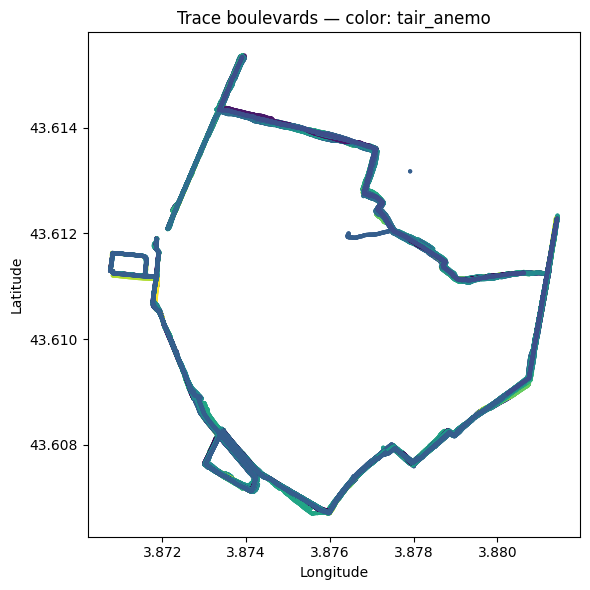

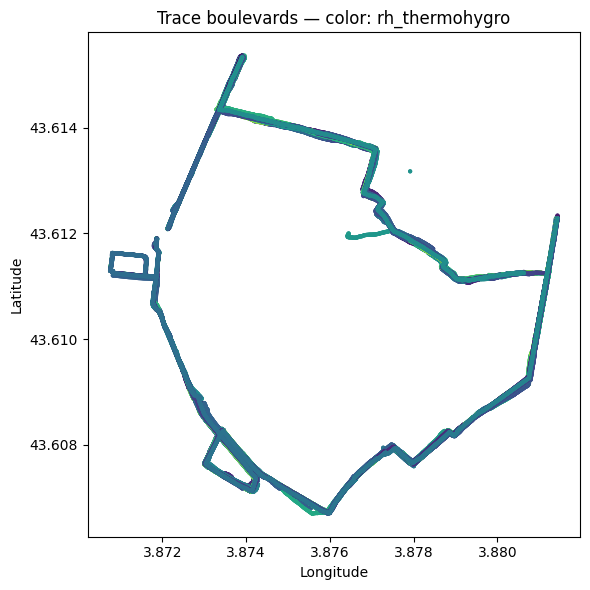

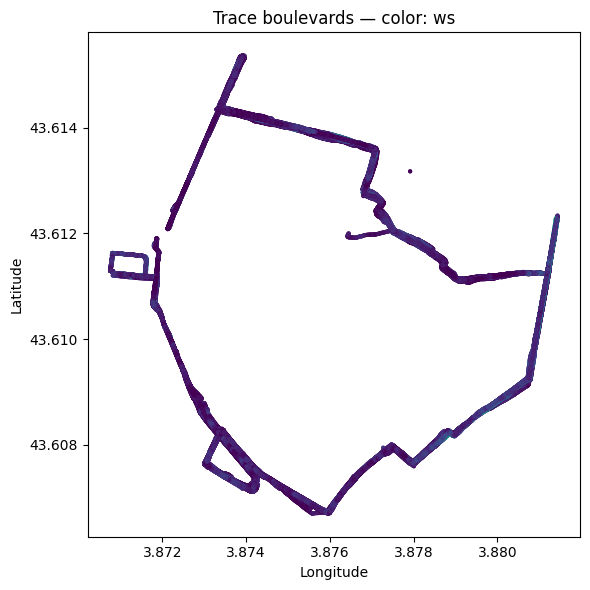

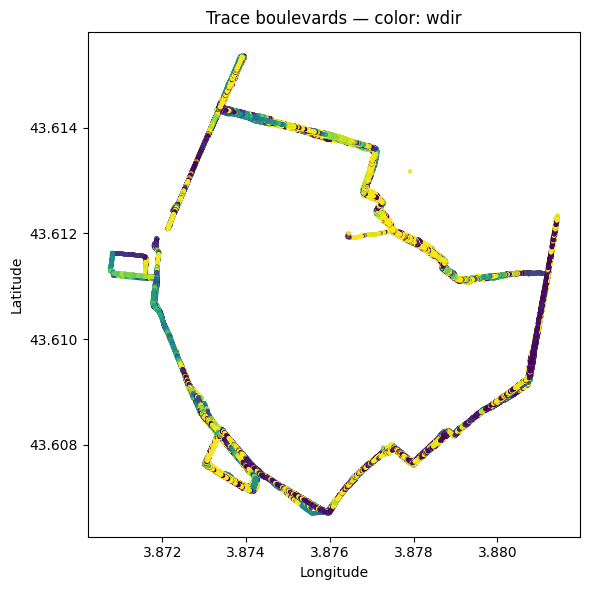

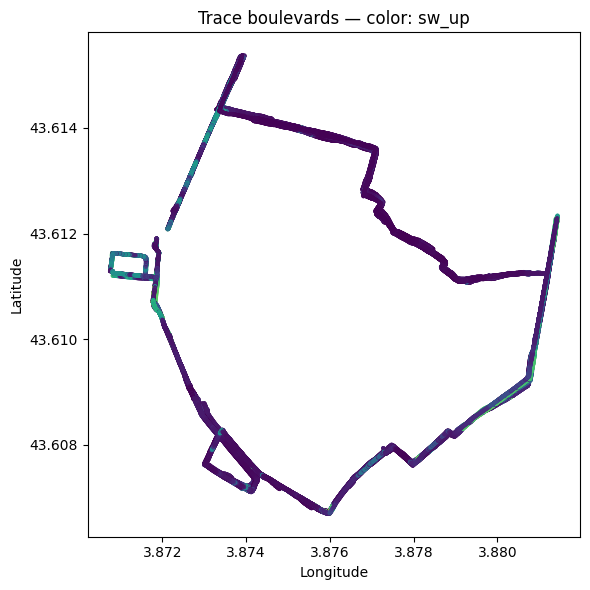

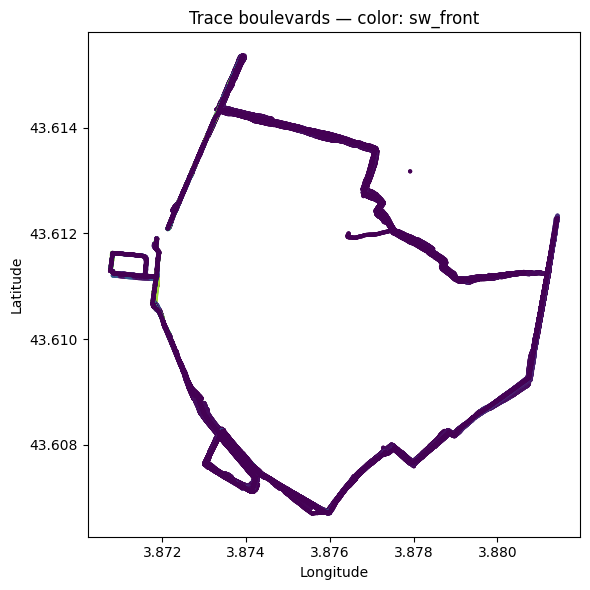

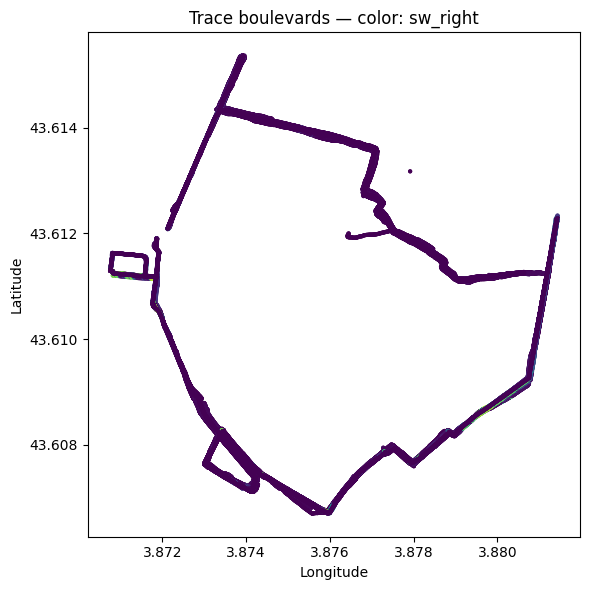

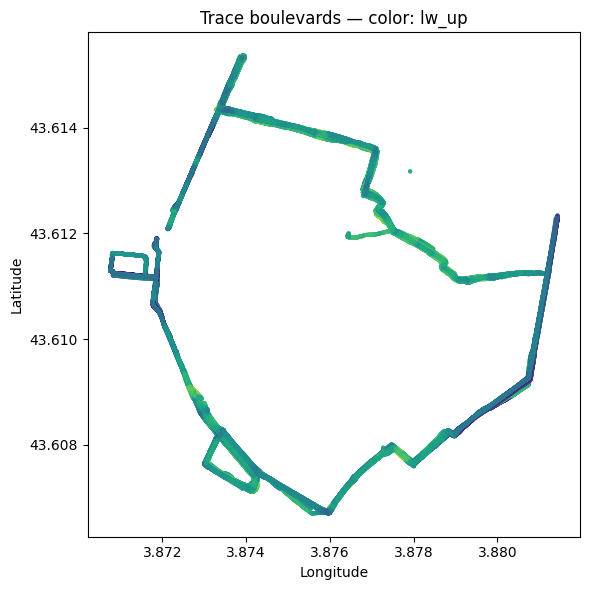

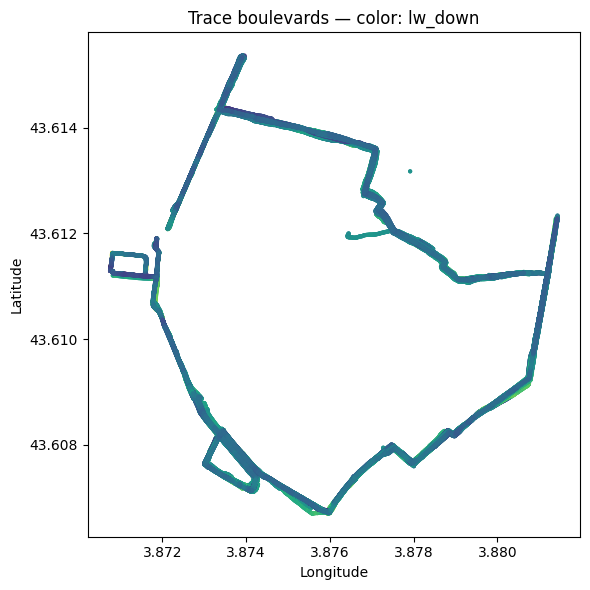

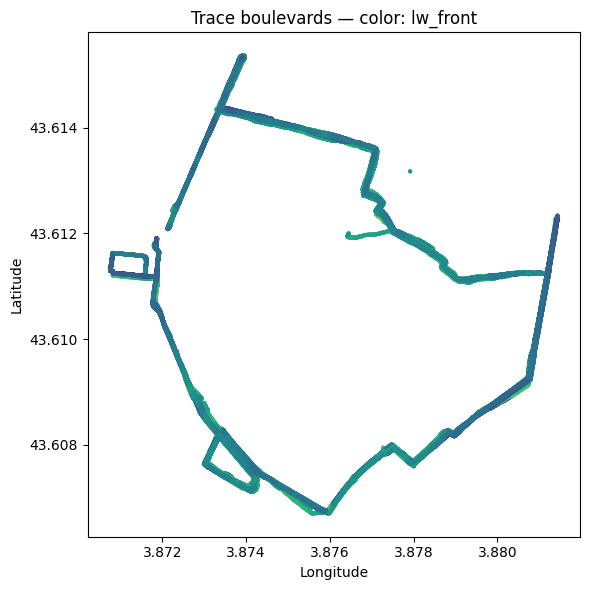

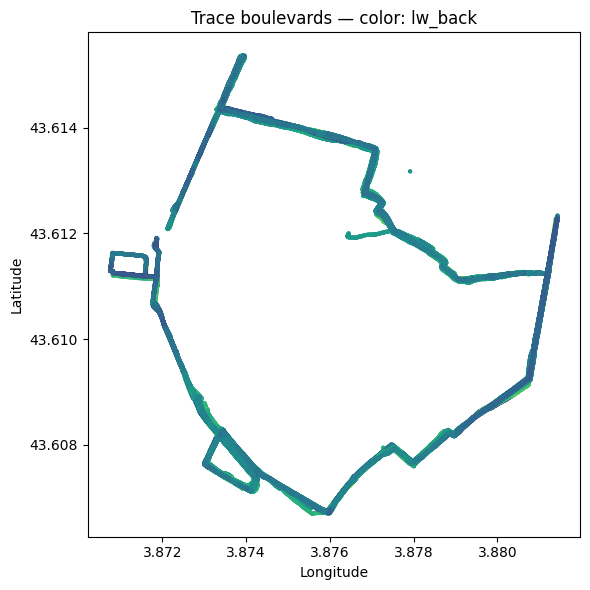

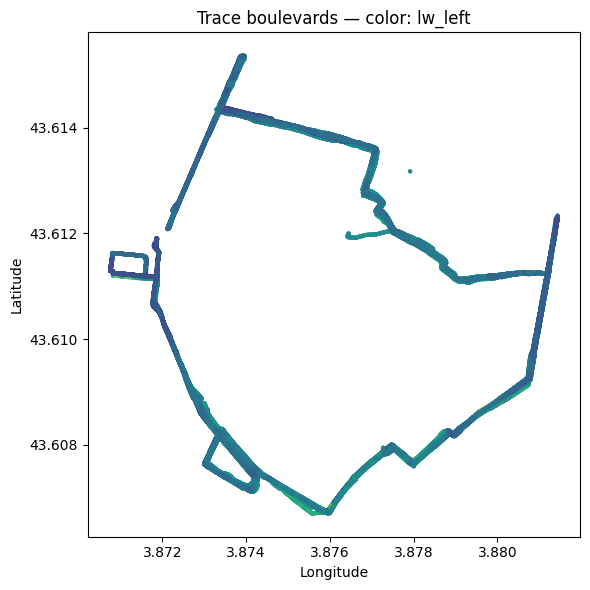

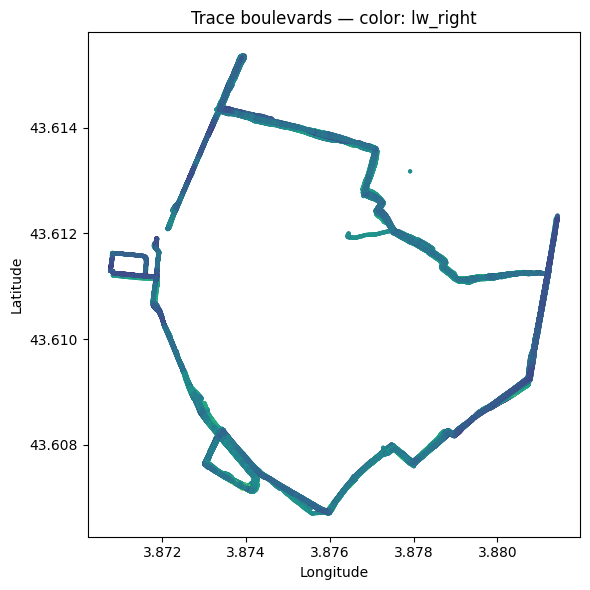

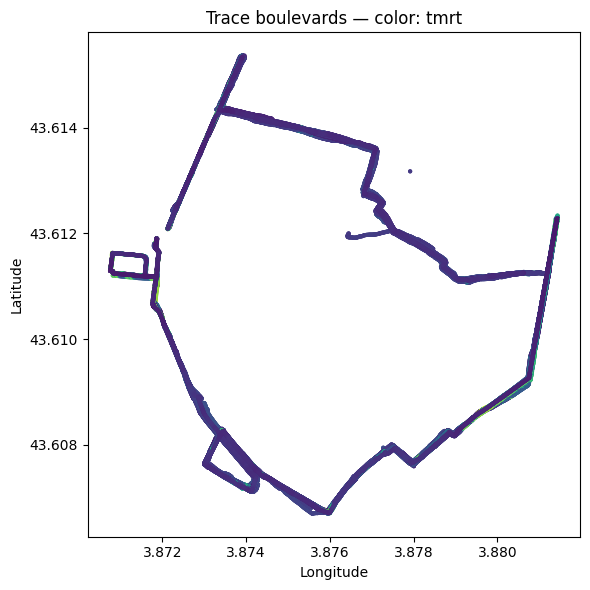

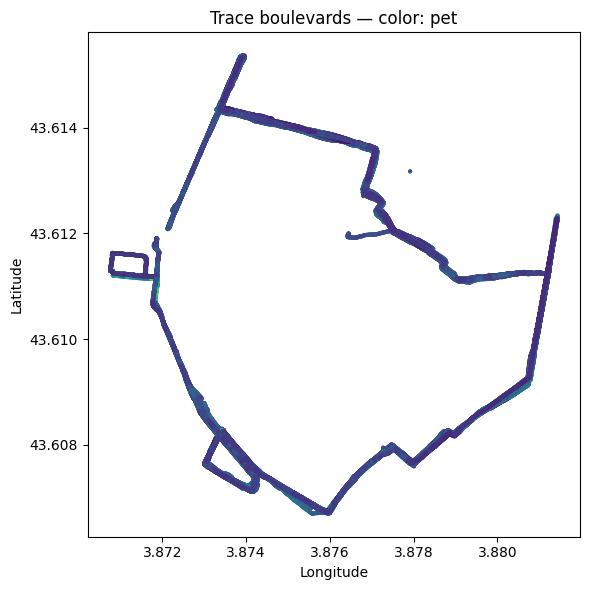

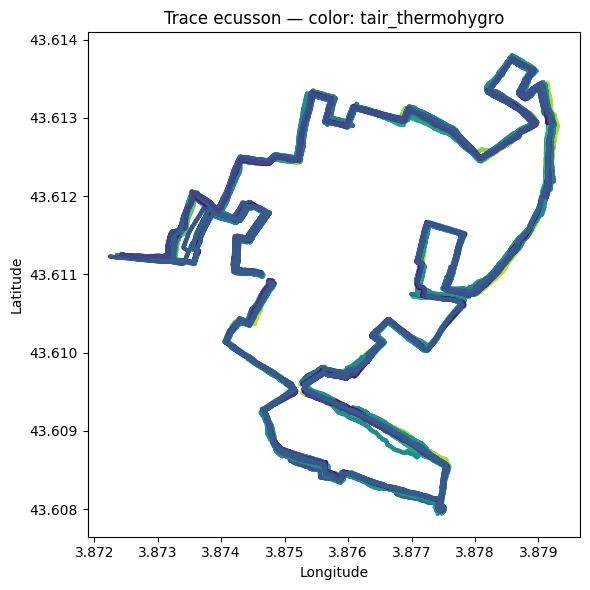

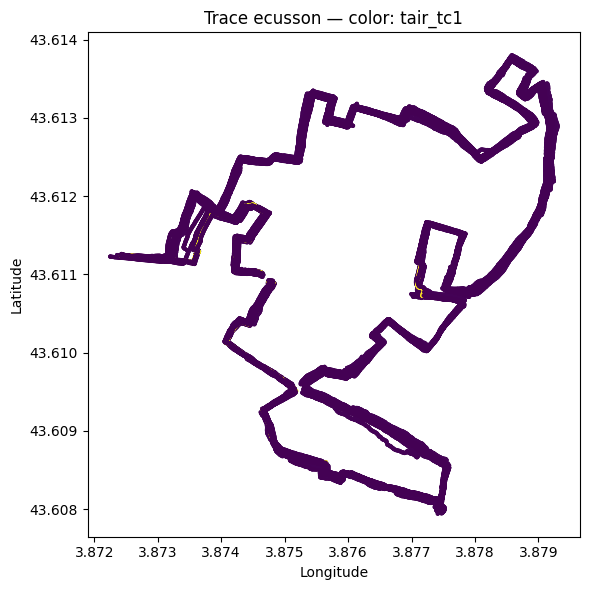

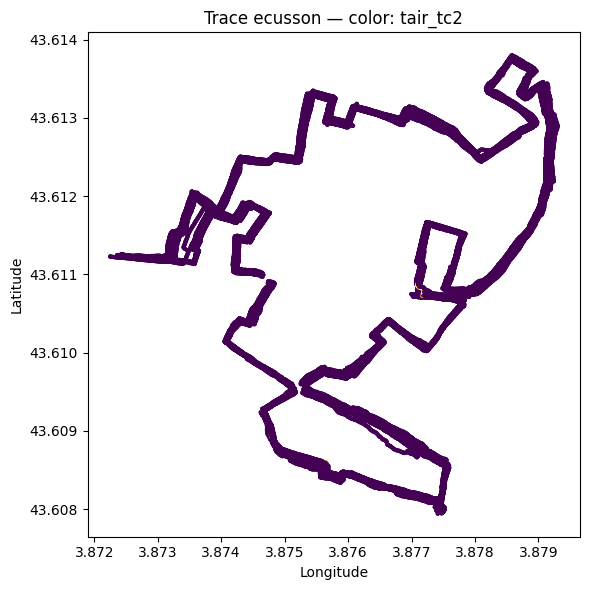

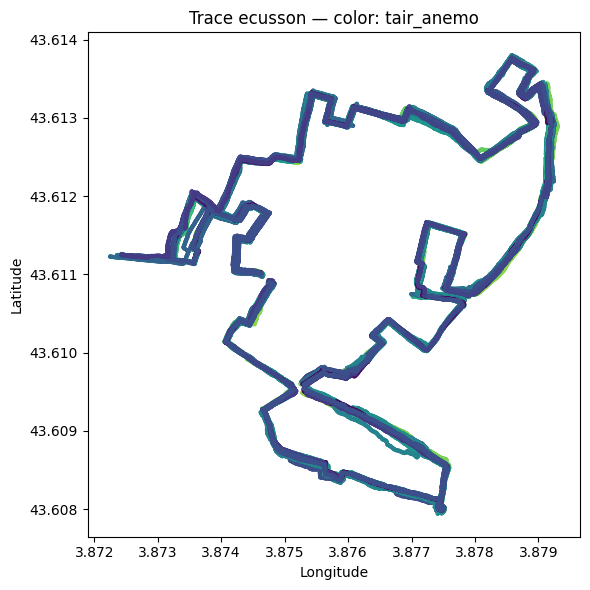

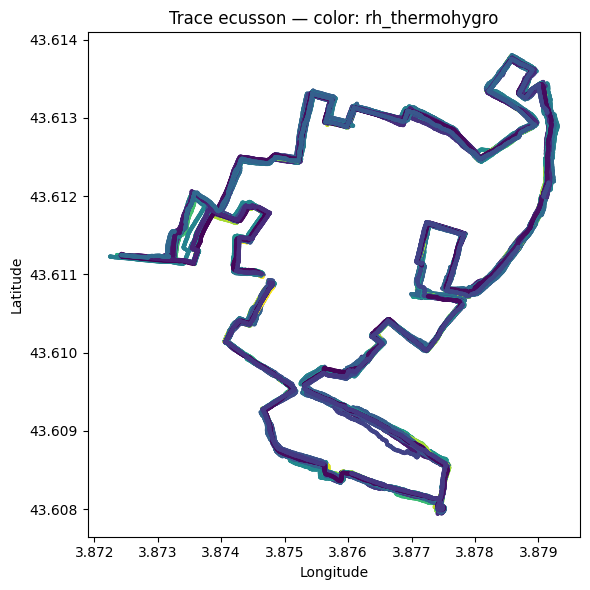

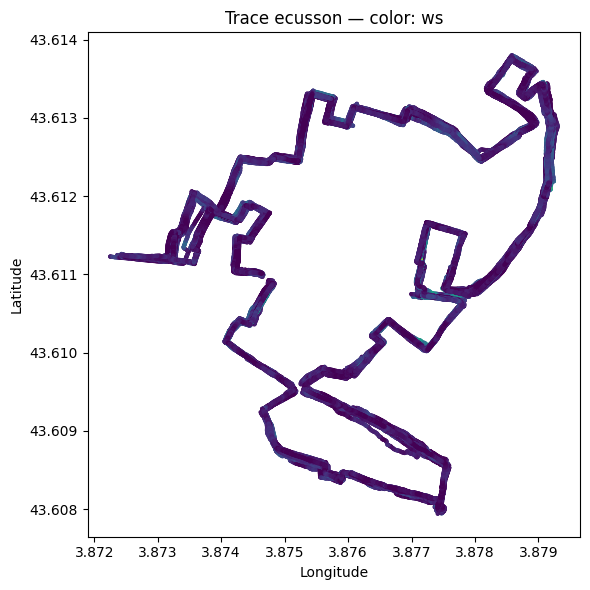

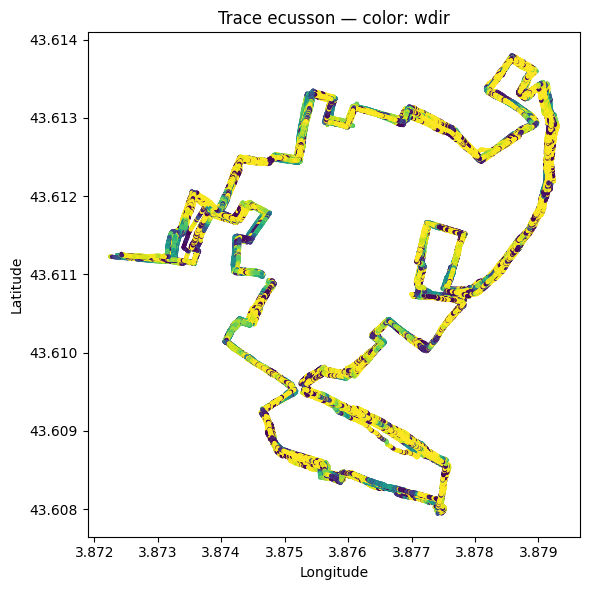

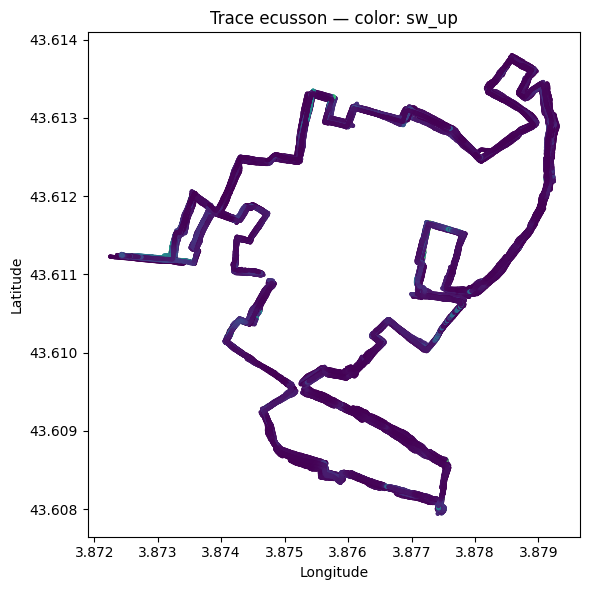

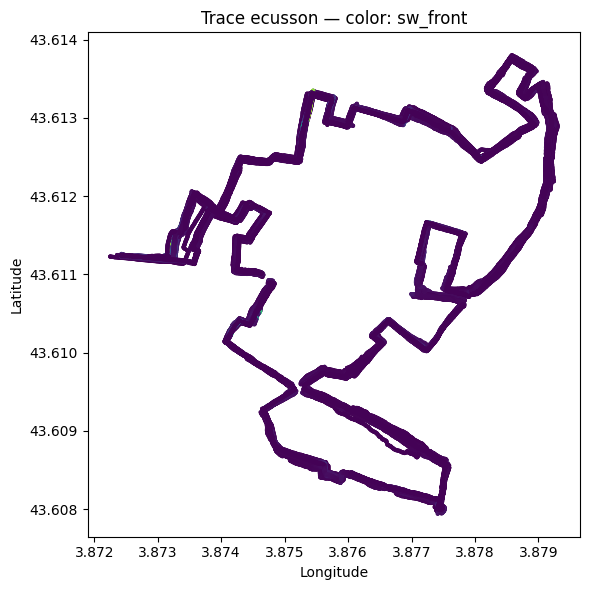

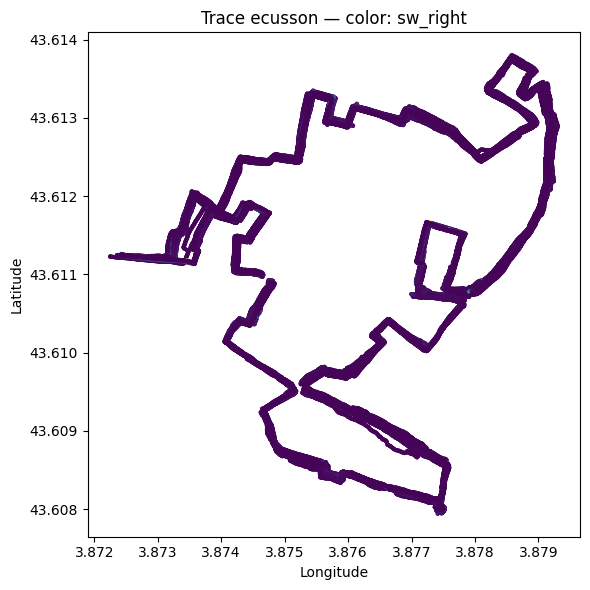

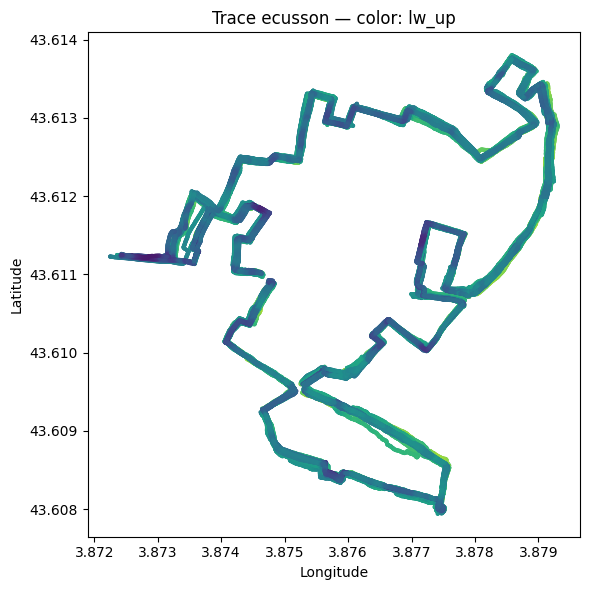

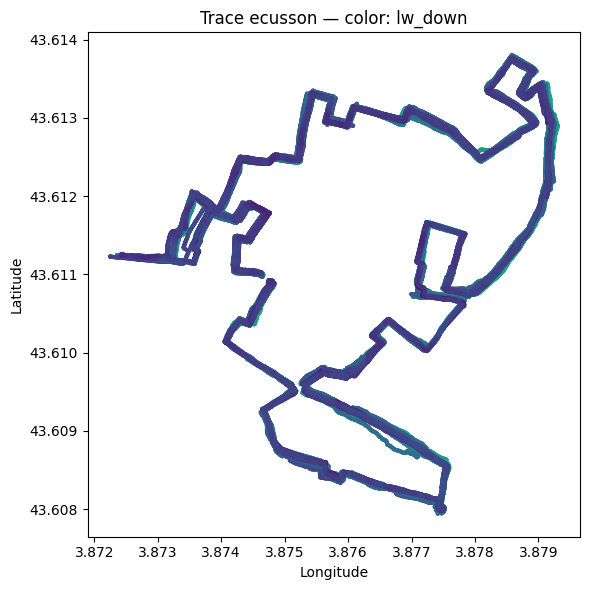

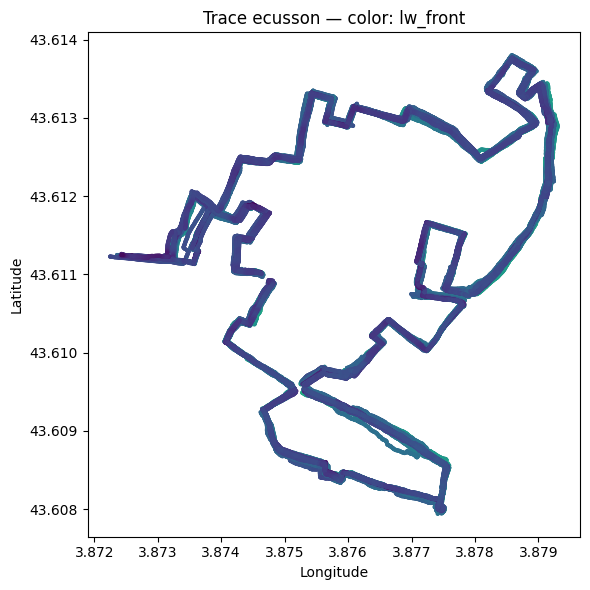

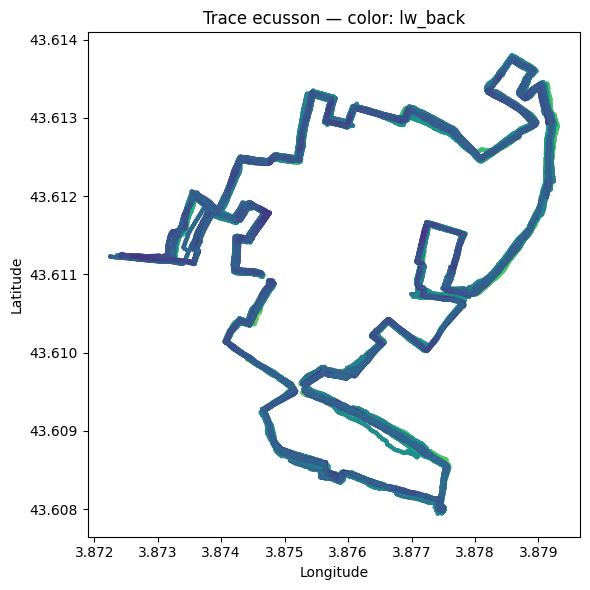

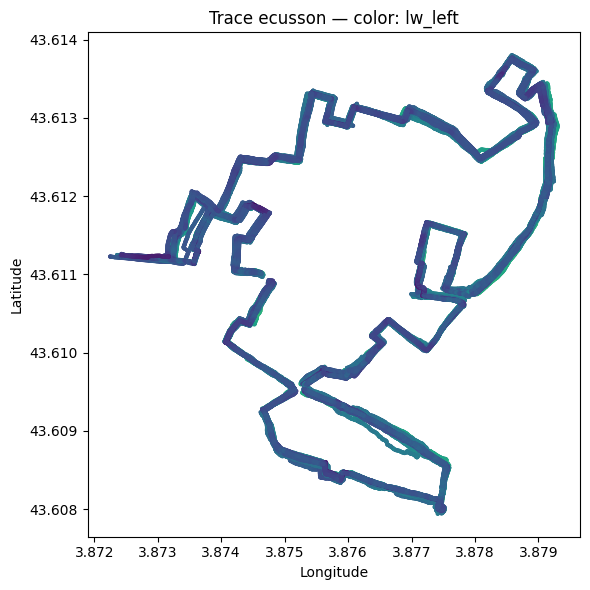

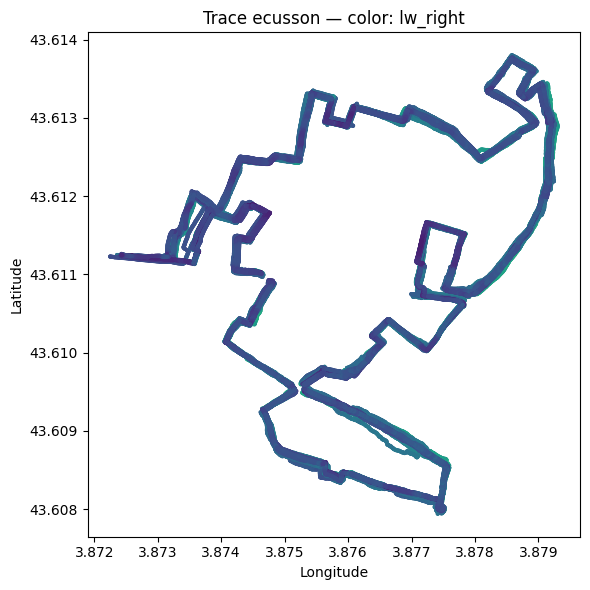

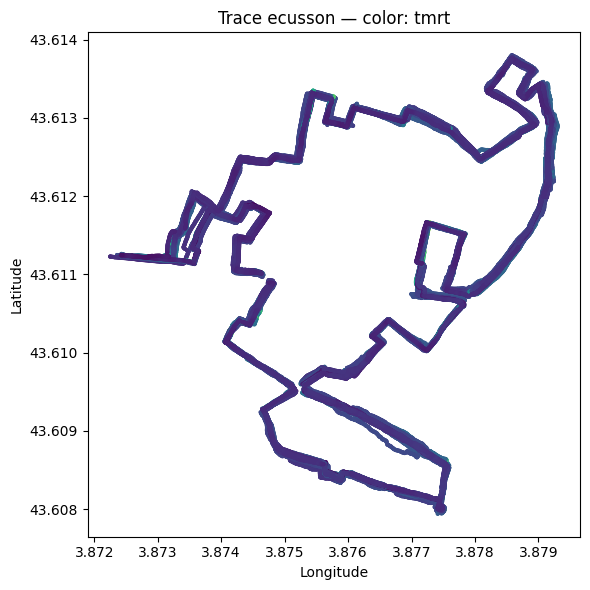

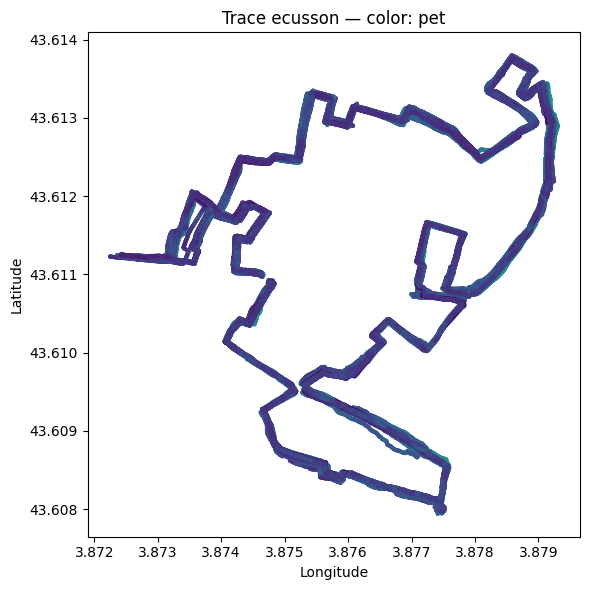

In [63]:
GPS = FIG_DIR / "gps"
create_folder(GPS)

ANT = GPS /"antigone"
BOU = GPS /"boulevards"
ECU = GPS /"ecusson"
create_folder (ANT)
create_folder (BOU)
create_folder(ECU)

# Boucle sur chaque parcours
for t, g in raw.groupby("track_id"):
    
    # Pour chaque variable météo
    for v in METEO:

        # Supprime les lignes avec des NaN pour cette variable
        s = g.dropna(subset=["lat", "lon", v])
        if s.empty:
            continue

        # Tracé de la carte
        plt.figure(figsize=(6, 6))
        plt.scatter(s["lon"], s["lat"], c=s[v], s=4)
        plt.title(f"Trace {t} — color: {v}")
        plt.xlabel("Longitude")
        plt.ylabel("Latitude")
        plt.tight_layout()

        # Sauvegarde du graphique
        plt.savefig(GPS / f"{t}/map_{v}_{t}.png", dpi=150)